In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [4]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize


def train_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_params = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        if fold == 1:
            clf = RandomForestClassifier(random_state=random_state)
            search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist,
                n_iter=n_iter,
                cv=3,
                n_jobs=-1,
                verbose=1,
                scoring='f1_macro'
            )
            search.fit(X_train_scaled, y_train)
            best_params = search.best_params_
            print(f"[Fold 1] Best Parameters Found: {best_params}")

        model = RandomForestClassifier(**best_params, random_state=random_state)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        # AUC calculation
        classes = model.classes_
        y_val_bin = label_binarize(y_val, classes=classes)
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curves
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Average metrics
    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Feature importances
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    print("\nFeature Importances:")
    print(feature_importances)

    return best_model, best_scaler, best_fold, all_metrics




======= Training Phase 1 ========

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.93      0.84      1785
           1       0.66      0.36      0.46       604
           2       0.49      0.36      0.42       258
           3       0.32      0.20      0.25        59
           4       0.17      0.11      0.13         9

    accuracy                           0.73      2715
   macro avg       0.48      0.39      0.42      2715
weighted avg       0.71      0.73      0.70      2715



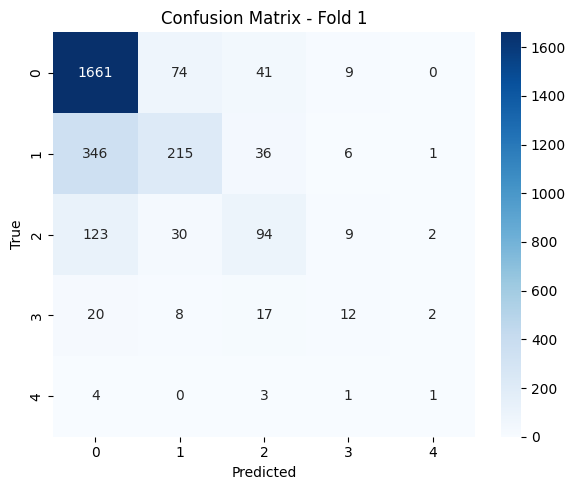

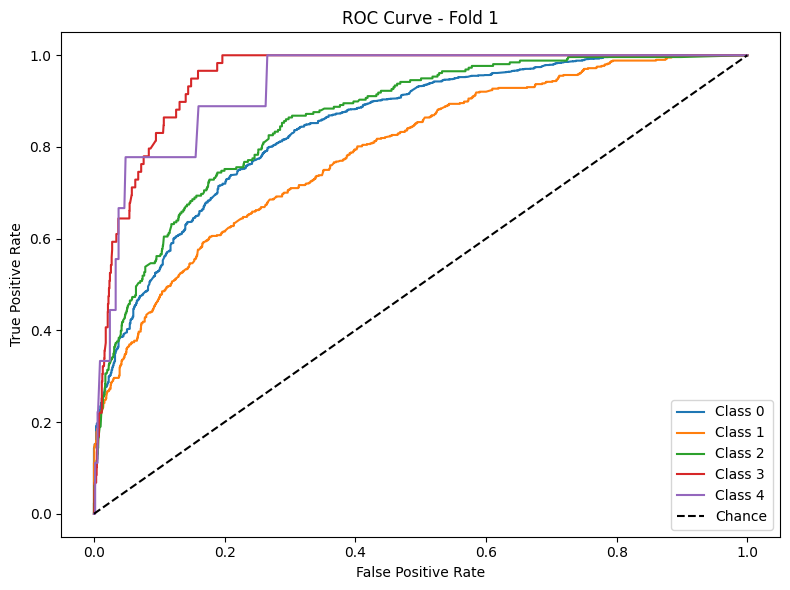


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84      1786
           1       0.60      0.35      0.44       603
           2       0.56      0.40      0.47       258
           3       0.44      0.25      0.32        59
           4       0.00      0.00      0.00         8

    accuracy                           0.73      2714
   macro avg       0.47      0.39      0.41      2714
weighted avg       0.70      0.73      0.70      2714



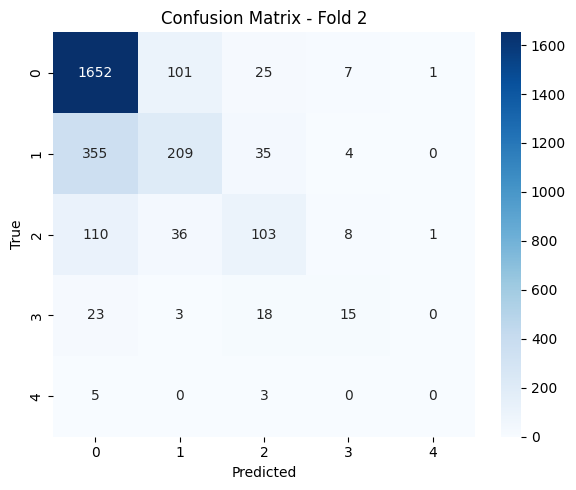

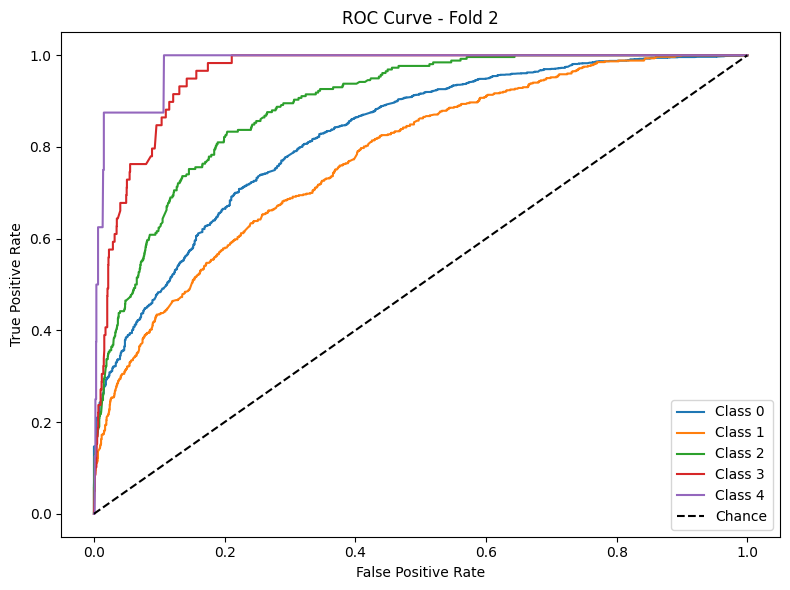


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.84      1786
           1       0.61      0.38      0.46       603
           2       0.53      0.36      0.43       258
           3       0.54      0.34      0.42        59
           4       0.33      0.25      0.29         8

    accuracy                           0.73      2714
   macro avg       0.56      0.45      0.49      2714
weighted avg       0.70      0.73      0.70      2714



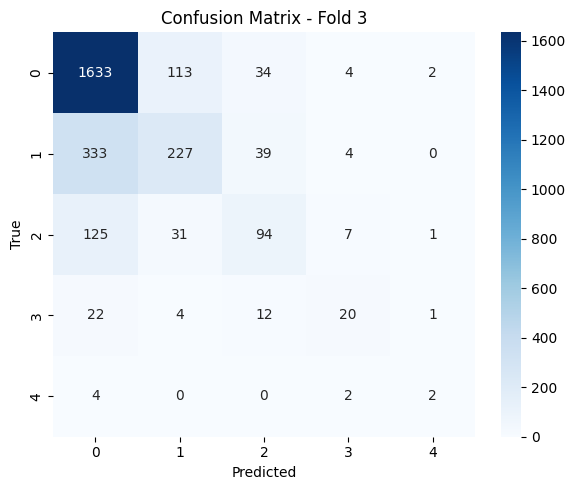

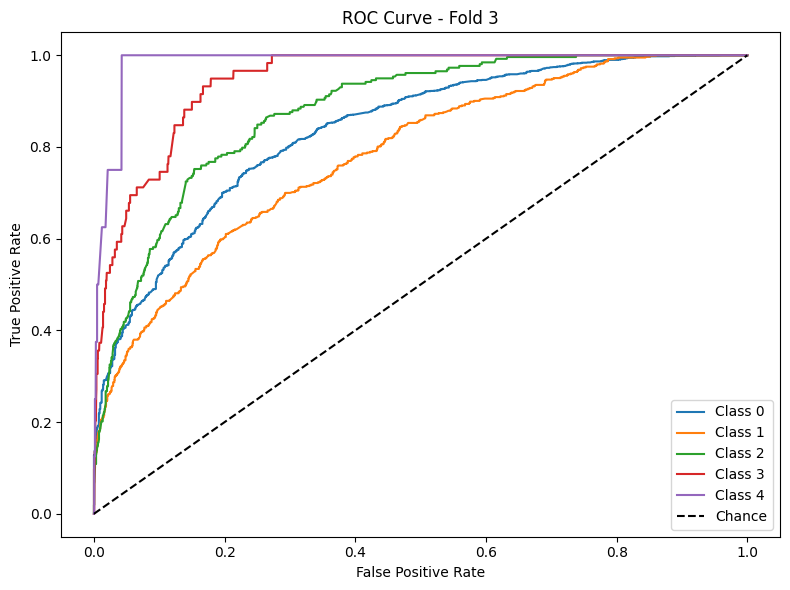

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.93      0.85      1785
           1       0.63      0.41      0.50       603
           2       0.59      0.41      0.49       258
           3       0.33      0.19      0.24        59
           4       0.00      0.00      0.00         9

    accuracy                           0.75      2714
   macro avg       0.47      0.39      0.42      2714
weighted avg       0.72      0.75      0.72      2714



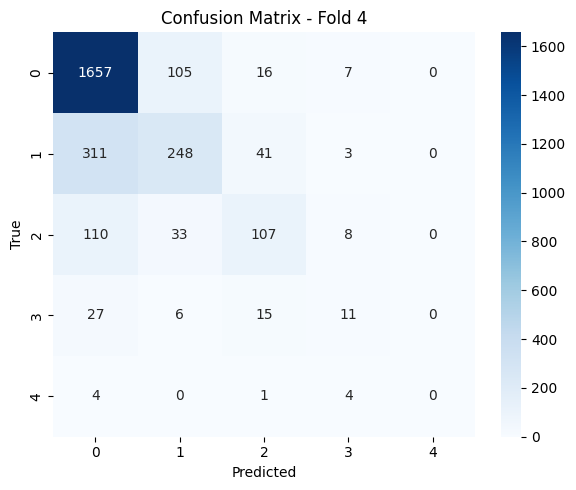

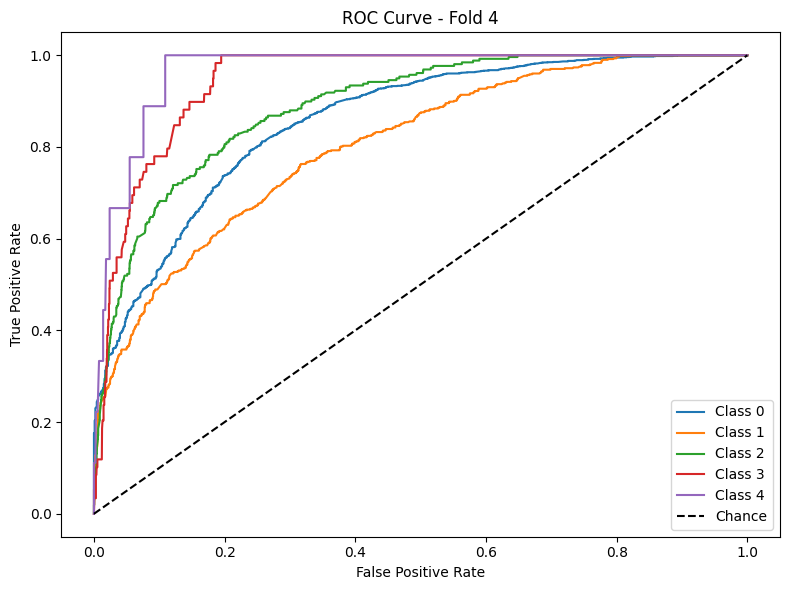

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.93      0.85      1785
           1       0.61      0.36      0.46       603
           2       0.55      0.38      0.45       258
           3       0.40      0.20      0.27        59
           4       0.00      0.00      0.00         9

    accuracy                           0.73      2714
   macro avg       0.47      0.37      0.40      2714
weighted avg       0.71      0.73      0.71      2714



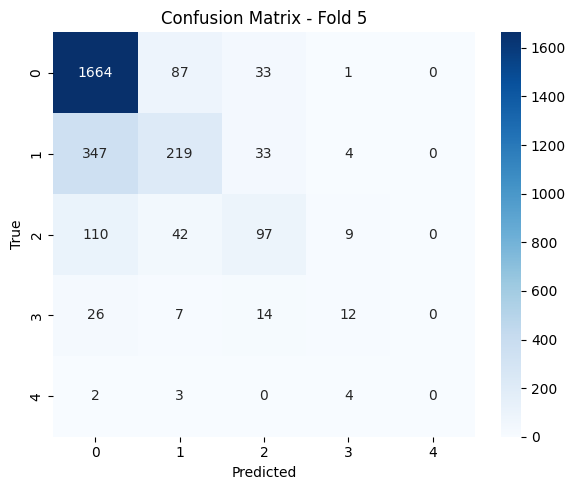

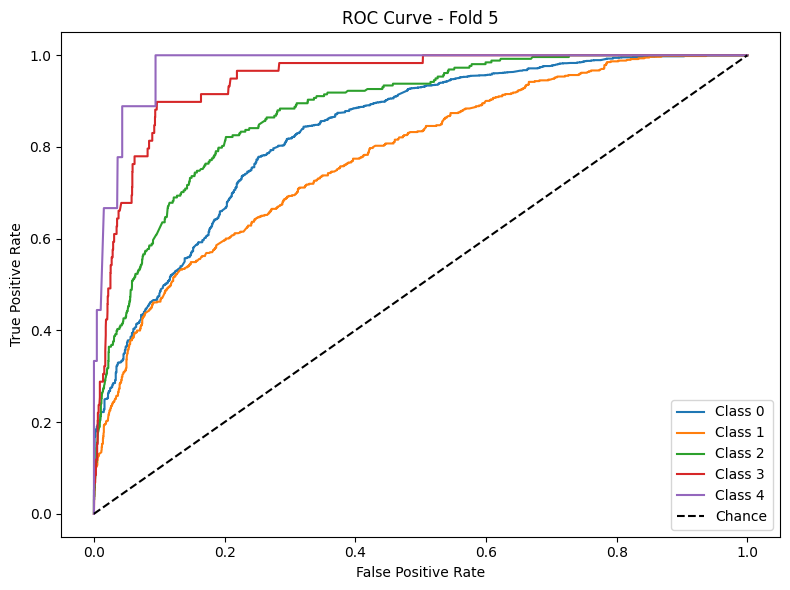


Average Accuracy: 0.7334
Average F1 Macro: 0.4281
Average AUC: 0.8849

Feature Importances:
remaining_time                         0.115062
cluster                                0.110836
eigenvector                            0.048588
degree                                 0.047904
total_words_phase1                     0.047547
school                                 0.044457
video                                  0.044076
closeness                              0.042182
assignment                             0.041408
exercise_correct_sum_1                 0.038359
encoded_field_sum                      0.037256
video_count                            0.034643
duration_days                          0.034481
user_month                             0.033718
exercise_count                         0.033039
total_neutral1                         0.027569
exercise_perc_real_score_mean_1        0.025149
chapter_count                          0.023348
exercise_correct_mean_1                0.02

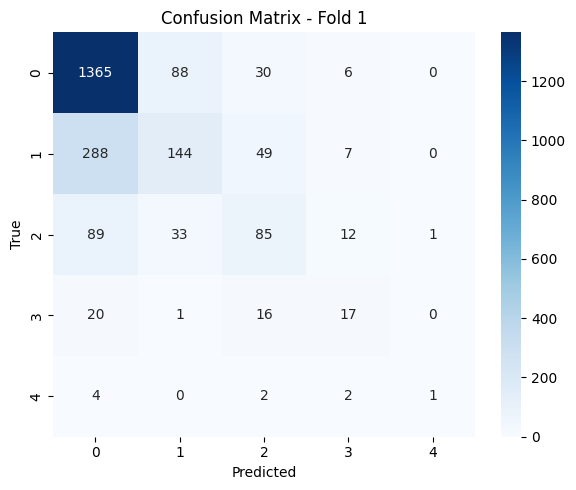

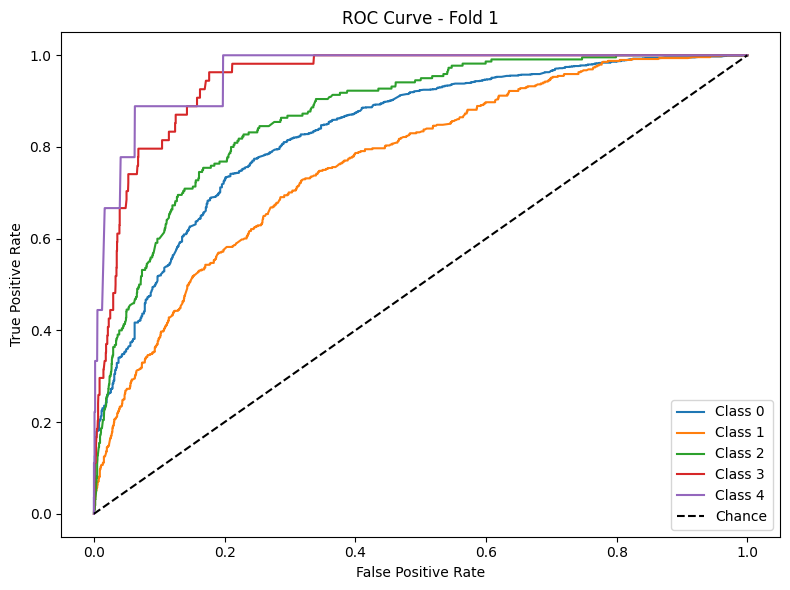


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83      1489
           1       0.52      0.31      0.39       489
           2       0.45      0.34      0.39       219
           3       0.33      0.24      0.28        55
           4       0.00      0.00      0.00         8

    accuracy                           0.71      2260
   macro avg       0.42      0.36      0.38      2260
weighted avg       0.67      0.71      0.68      2260



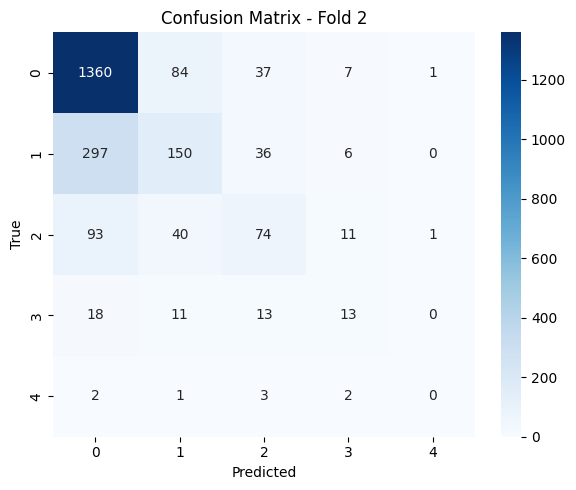

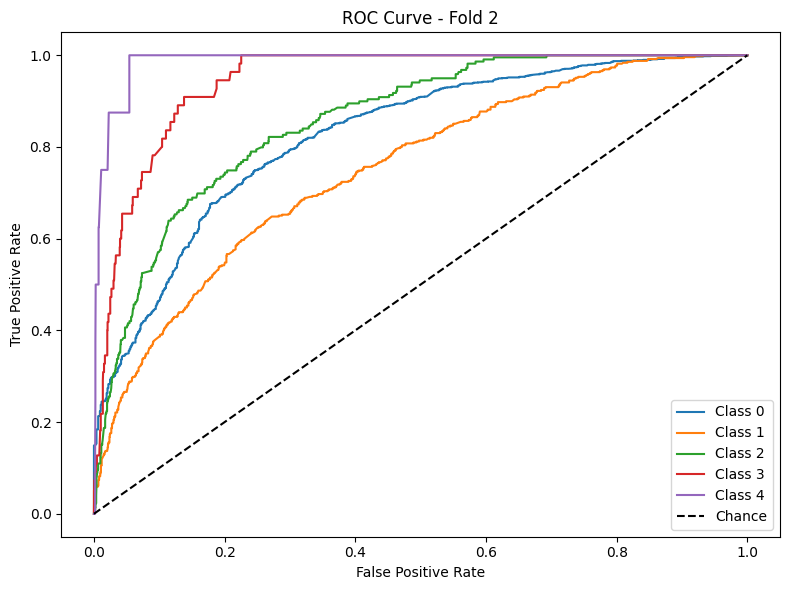


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83      1489
           1       0.51      0.30      0.38       489
           2       0.49      0.40      0.44       219
           3       0.31      0.22      0.26        54
           4       0.50      0.12      0.20         8

    accuracy                           0.71      2259
   macro avg       0.52      0.39      0.42      2259
weighted avg       0.68      0.71      0.68      2259



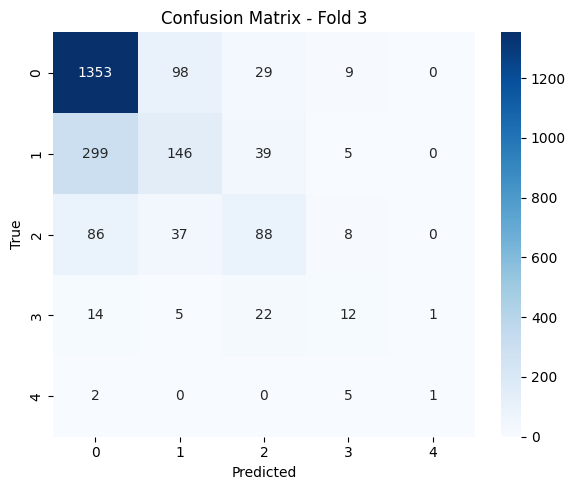

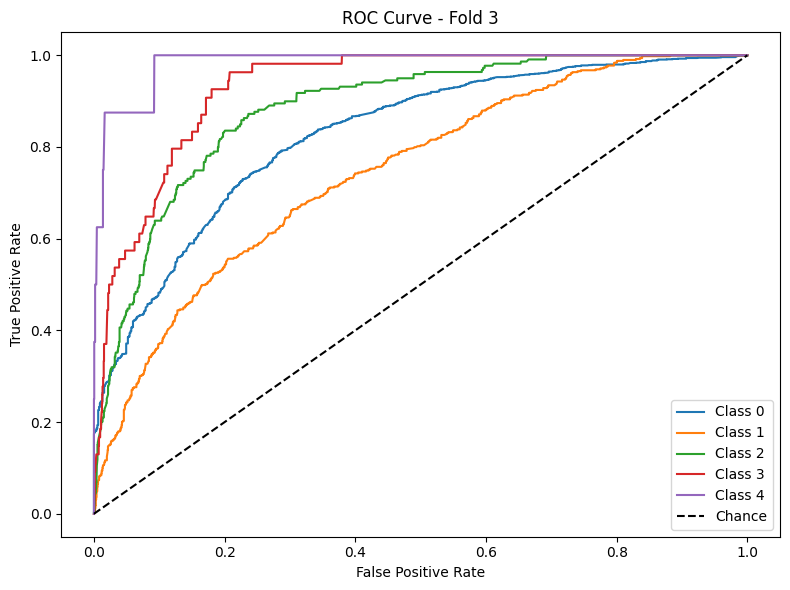


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84      1489
           1       0.60      0.31      0.41       489
           2       0.47      0.38      0.42       219
           3       0.39      0.26      0.31        54
           4       0.80      0.50      0.62         8

    accuracy                           0.72      2259
   macro avg       0.60      0.47      0.52      2259
weighted avg       0.69      0.72      0.69      2259



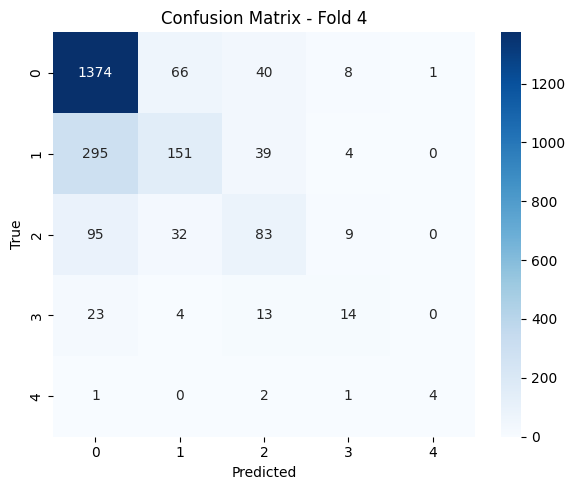

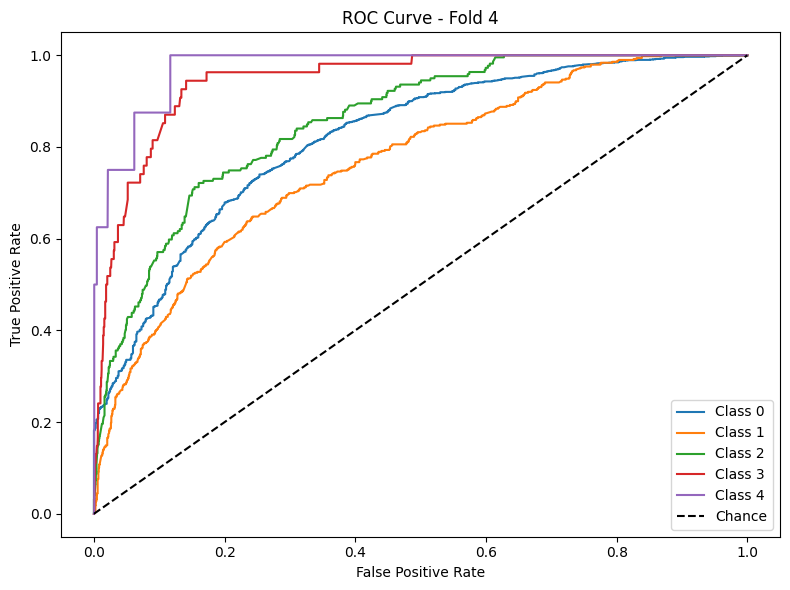


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.84      1490
           1       0.56      0.35      0.43       488
           2       0.50      0.40      0.45       219
           3       0.22      0.11      0.15        54
           4       0.20      0.12      0.15         8

    accuracy                           0.72      2259
   macro avg       0.45      0.38      0.40      2259
weighted avg       0.69      0.72      0.70      2259



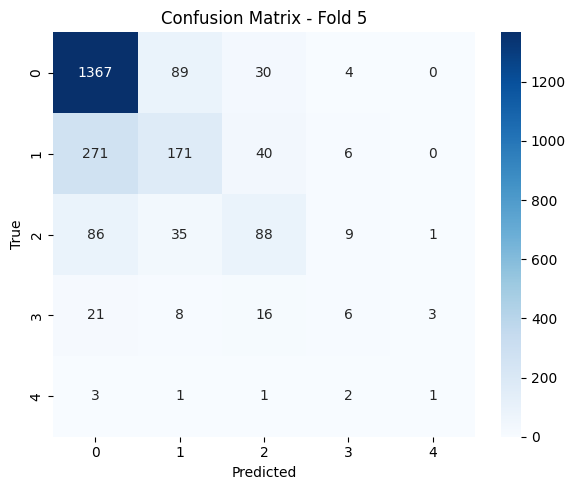

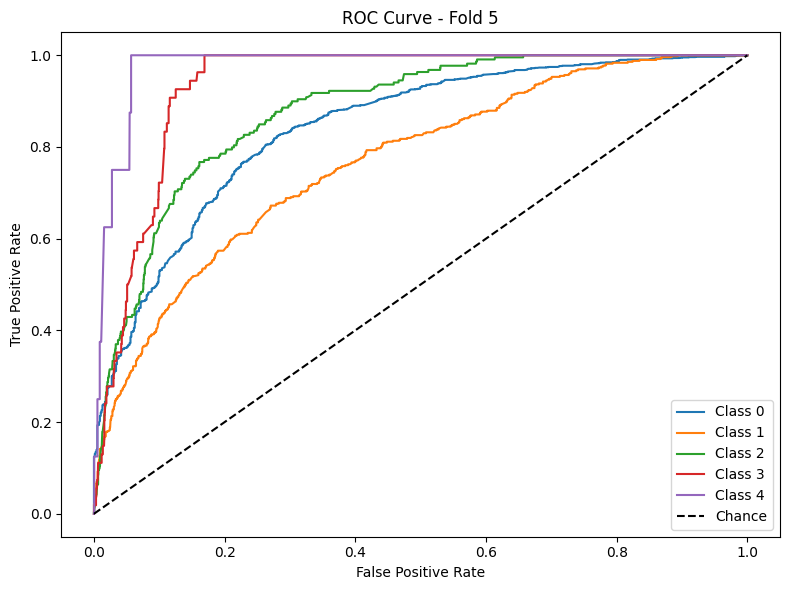


Average Accuracy: 0.7142
Average F1 Macro: 0.4315
Average AUC: 0.8754

Feature Importances:
cluster                                0.104252
remaining_time                         0.097446
eigenvector                            0.053038
degree                                 0.052384
closeness                              0.046757
video                                  0.044347
school                                 0.041427
encoded_field_sum                      0.040540
exercise_count                         0.040511
video_count                            0.039475
assignment                             0.039194
total_words_phase1                     0.037828
duration_days                          0.035302
user_month                             0.031427
chapter_count                          0.026228
total_neutral1                         0.023960
total_words_phase2                     0.022617
entropy_time_comment_phase1            0.016023
user_time_since_last_course            0.01

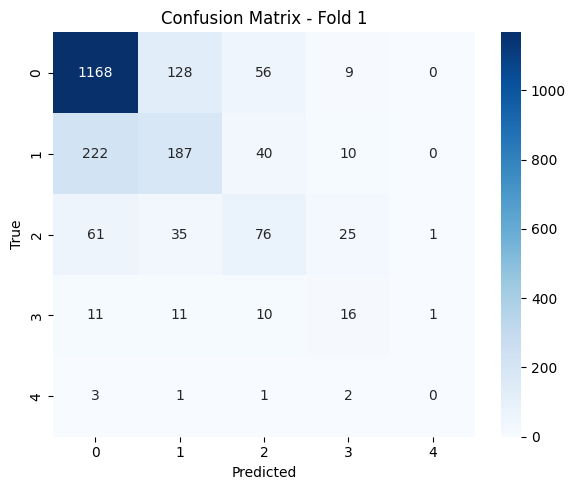

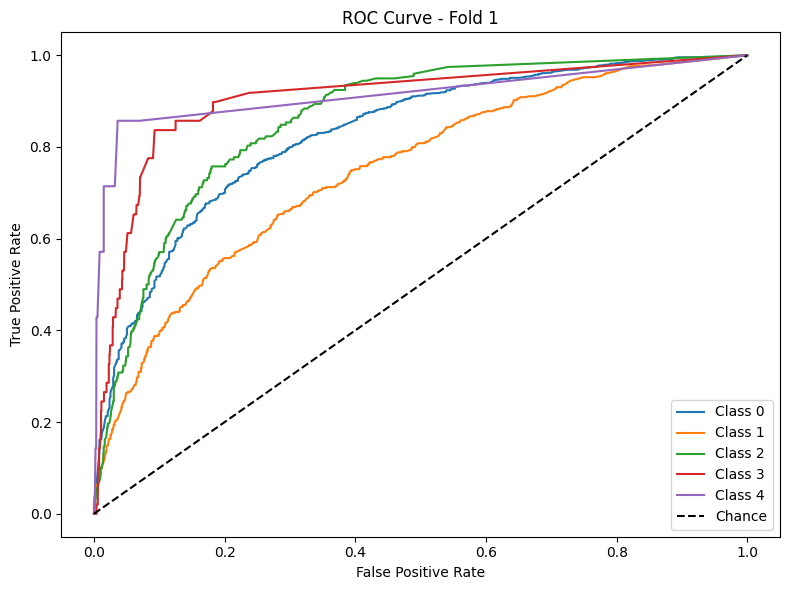


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83      1360
           1       0.52      0.39      0.45       459
           2       0.45      0.39      0.42       198
           3       0.32      0.24      0.28        50
           4       1.00      0.14      0.25         7

    accuracy                           0.71      2074
   macro avg       0.62      0.41      0.44      2074
weighted avg       0.68      0.71      0.69      2074



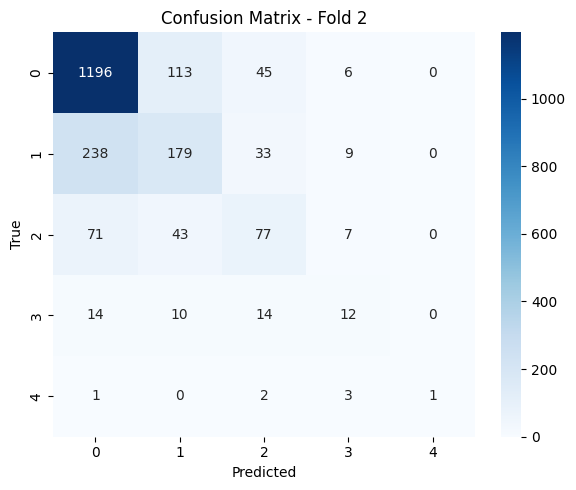

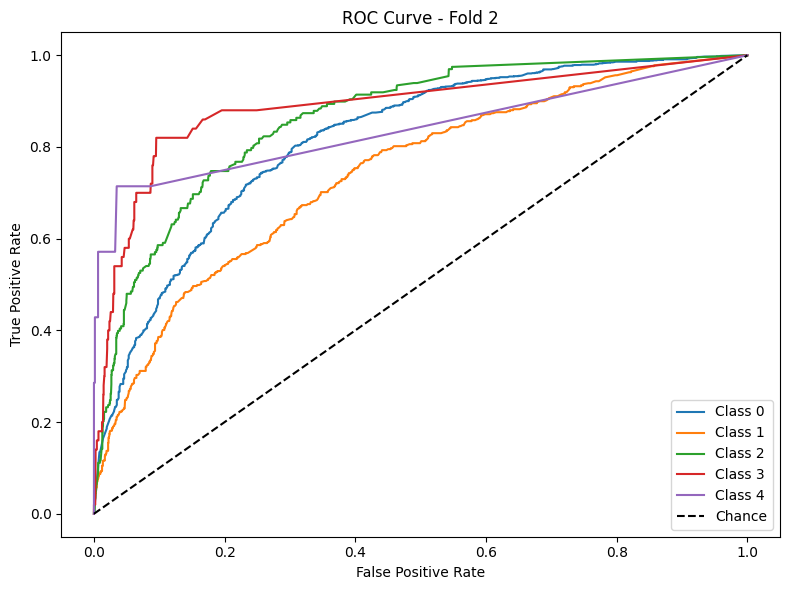


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83      1360
           1       0.47      0.38      0.42       459
           2       0.38      0.34      0.36       198
           3       0.35      0.32      0.33        50
           4       0.50      0.29      0.36         7

    accuracy                           0.69      2074
   macro avg       0.50      0.44      0.46      2074
weighted avg       0.67      0.69      0.68      2074



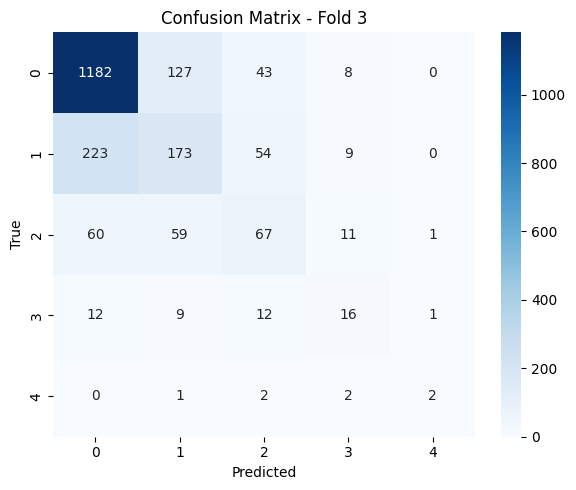

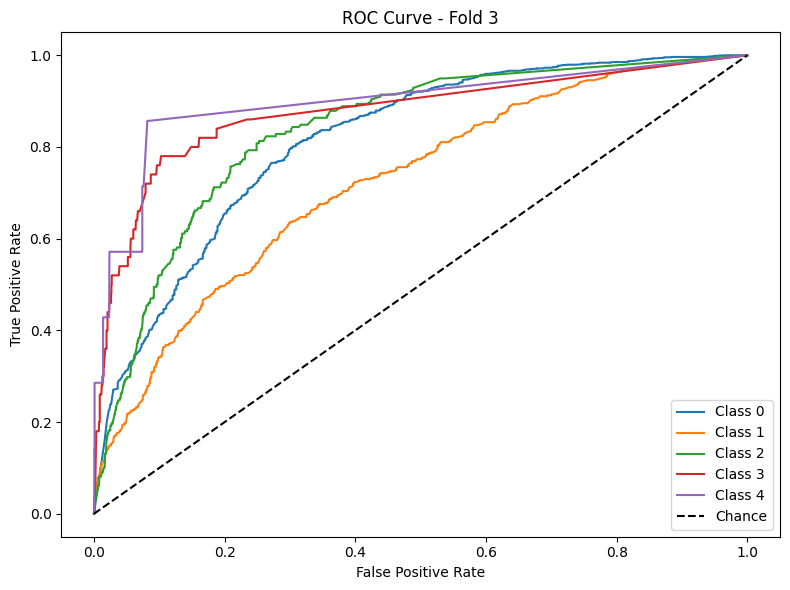


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.85      0.81      1360
           1       0.46      0.37      0.41       459
           2       0.45      0.38      0.41       198
           3       0.37      0.30      0.33        50
           4       0.25      0.14      0.18         7

    accuracy                           0.68      2074
   macro avg       0.46      0.41      0.43      2074
weighted avg       0.66      0.68      0.67      2074



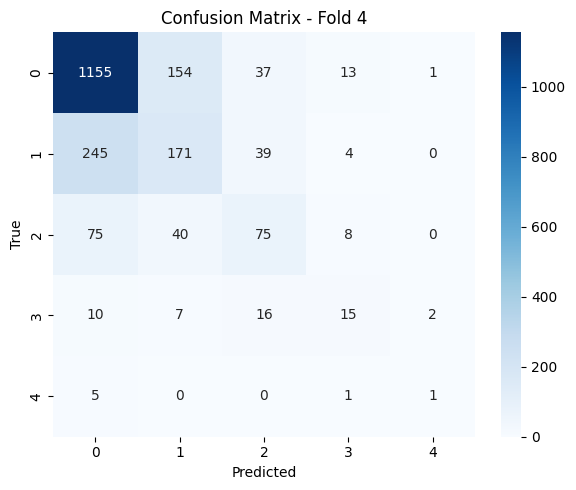

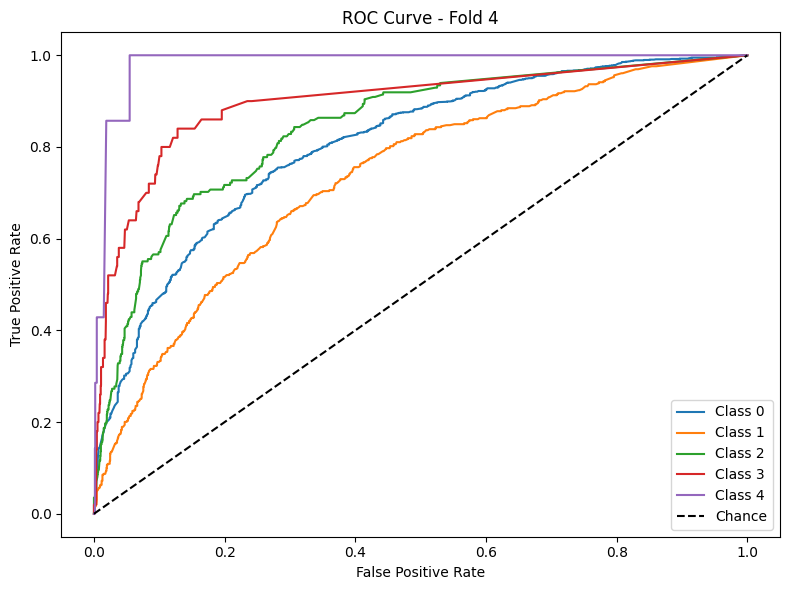


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82      1360
           1       0.47      0.38      0.42       460
           2       0.44      0.42      0.43       197
           3       0.38      0.35      0.36        49
           4       0.33      0.14      0.20         7

    accuracy                           0.69      2073
   macro avg       0.48      0.43      0.45      2073
weighted avg       0.68      0.69      0.68      2073



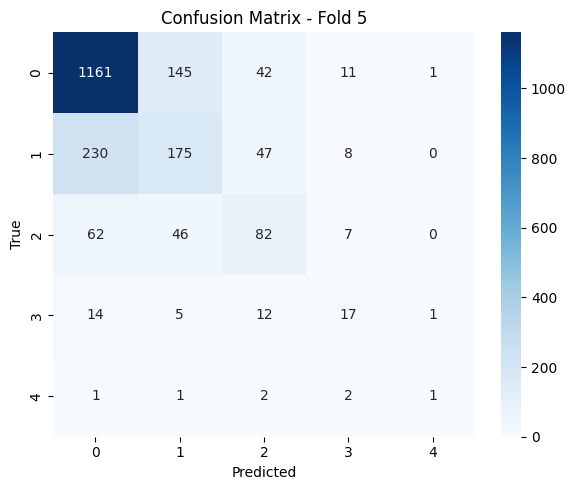

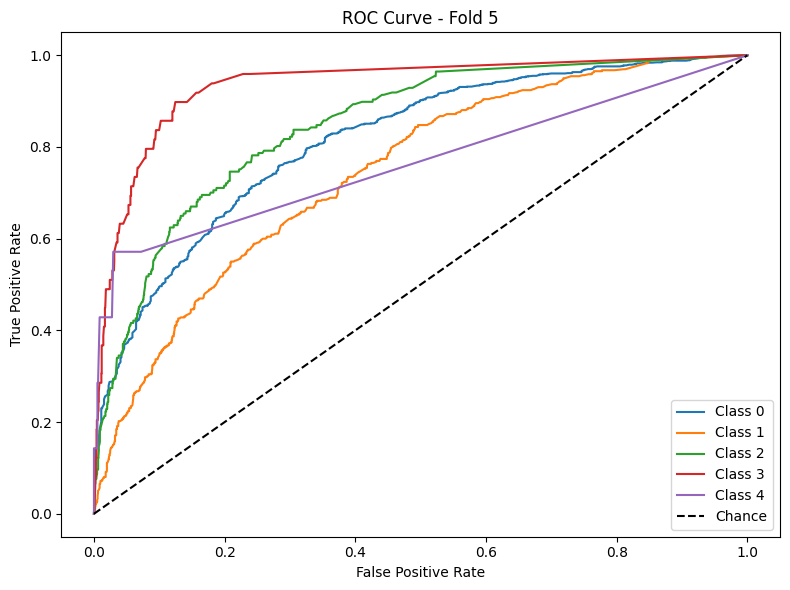


Average Accuracy: 0.6949
Average F1 Macro: 0.4348
Average AUC: 0.8363

Feature Importances:
cluster                                0.228626
remaining_time                         0.147314
total_words_phase1                     0.046903
eigenvector                            0.036861
degree                                 0.035053
school                                 0.030707
closeness                              0.028751
total_neutral1                         0.026173
user_month                             0.025053
video                                  0.024770
total_words_phase3                     0.024223
video_count                            0.022445
encoded_field_sum                      0.021500
exercise_count                         0.020963
total_words_phase2                     0.020723
assignment                             0.020549
duration_days                          0.019446
user_time_since_last_course            0.017166
total_neutral3                         0.01

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84      1000
           1       0.52      0.39      0.44       355
           2       0.40      0.33      0.36       139
           3       0.36      0.36      0.36        39
           4       0.00      0.00      0.00         6

    accuracy                           0.71      1539
   macro avg       0.42      0.39      0.40      1539
weighted avg       0.68      0.71      0.69      1539



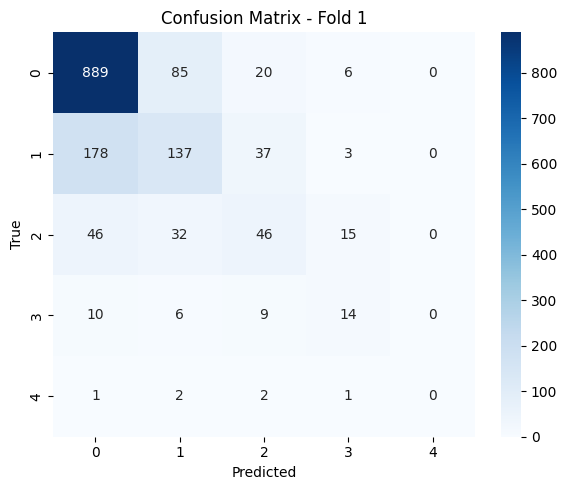

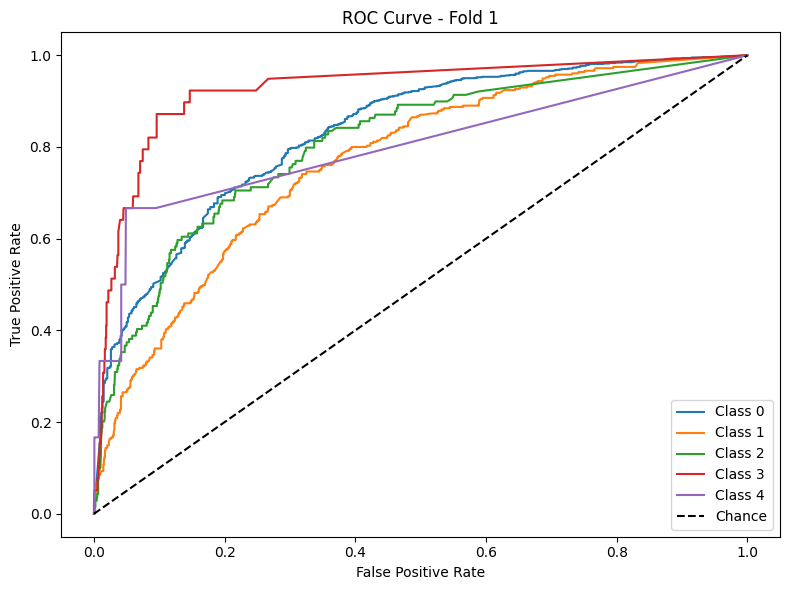


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      1000
           1       0.55      0.45      0.49       355
           2       0.51      0.43      0.47       139
           3       0.41      0.42      0.42        40
           4       0.00      0.00      0.00         5

    accuracy                           0.72      1539
   macro avg       0.46      0.44      0.44      1539
weighted avg       0.71      0.72      0.71      1539



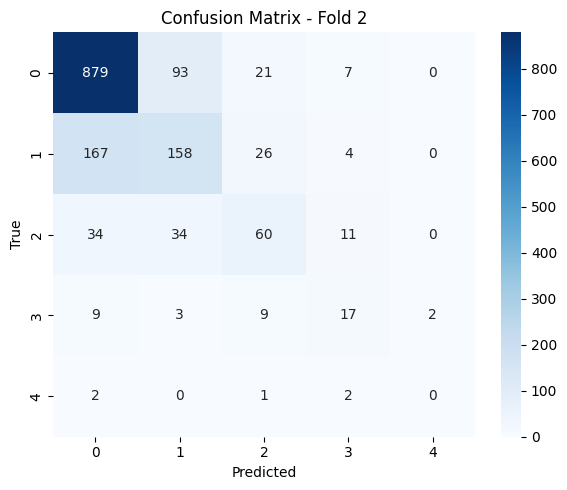

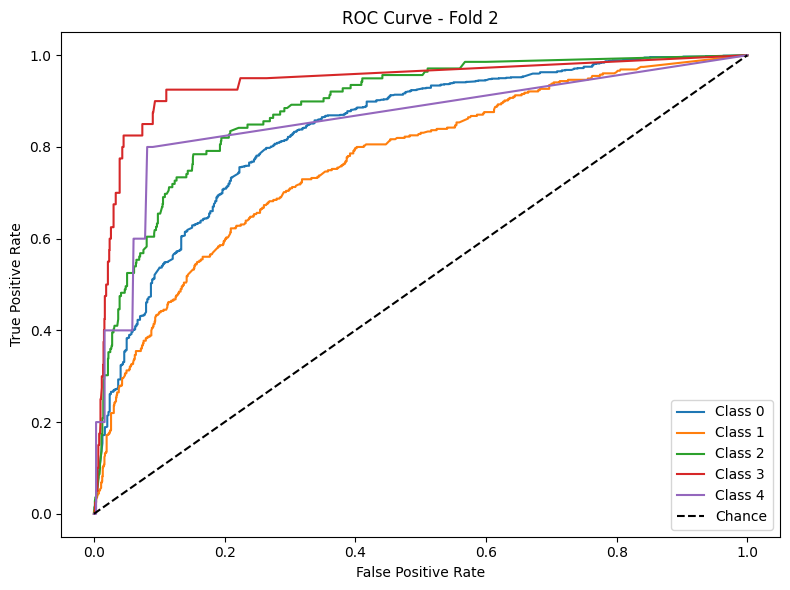


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       999
           1       0.57      0.47      0.52       355
           2       0.52      0.42      0.47       139
           3       0.43      0.40      0.42        40
           4       0.00      0.00      0.00         6

    accuracy                           0.73      1539
   macro avg       0.46      0.43      0.45      1539
weighted avg       0.71      0.73      0.72      1539



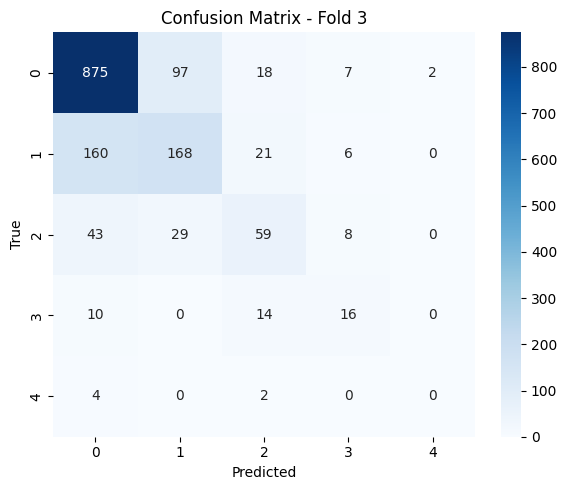

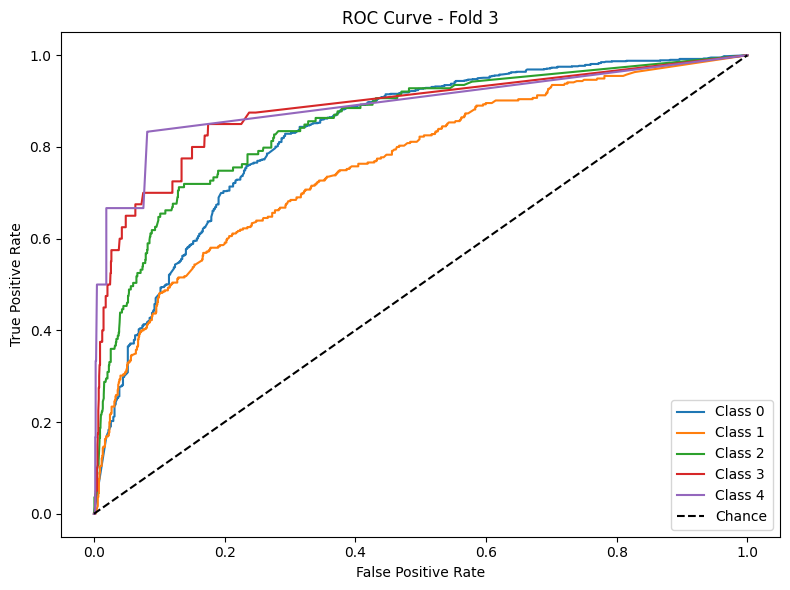


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       999
           1       0.57      0.42      0.48       356
           2       0.51      0.38      0.44       138
           3       0.32      0.28      0.30        39
           4       0.00      0.00      0.00         6

    accuracy                           0.72      1538
   macro avg       0.44      0.40      0.41      1538
weighted avg       0.70      0.72      0.71      1538



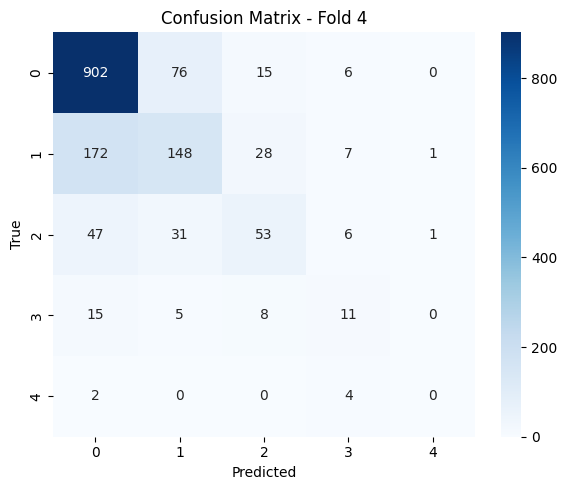

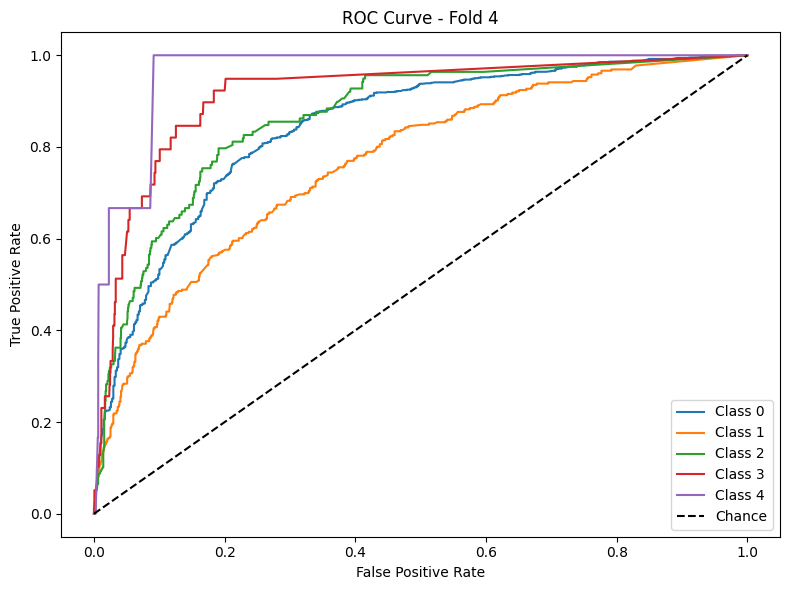


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       999
           1       0.52      0.42      0.47       356
           2       0.45      0.37      0.41       138
           3       0.41      0.41      0.41        39
           4       0.00      0.00      0.00         6

    accuracy                           0.71      1538
   macro avg       0.44      0.41      0.42      1538
weighted avg       0.69      0.71      0.69      1538



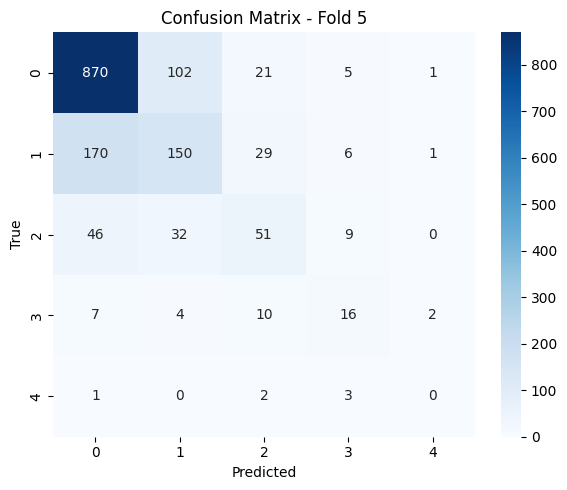

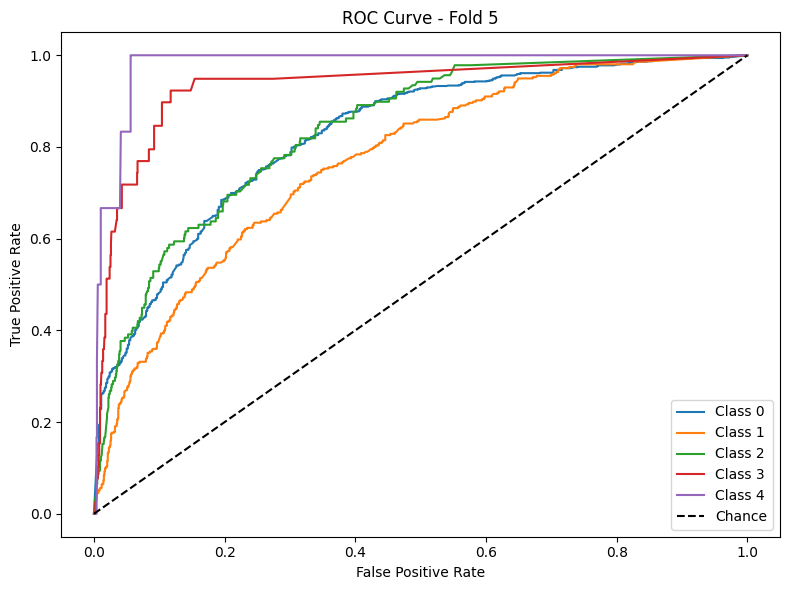


Average Accuracy: 0.7174
Average F1 Macro: 0.4256
Average AUC: 0.8535

Feature Importances:
cluster                                1.438410e-01
remaining_time                         9.412345e-02
eigenvector                            4.394005e-02
school                                 3.972204e-02
degree                                 3.568364e-02
assignment                             3.290944e-02
total_words_phase1                     3.119147e-02
video                                  2.982898e-02
video_count                            2.979280e-02
closeness                              2.915998e-02
encoded_field_sum                      2.909107e-02
duration_days                          2.599609e-02
user_month                             2.593869e-02
exercise_count                         2.401946e-02
total_words_phase4                     2.102970e-02
total_neutral1                         1.919878e-02
exercise_correct_sum_4                 1.869160e-02
chapter_count          

In [5]:
phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       568
           1       0.55      0.17      0.27        63
           2       0.35      0.14      0.20        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.83       698
   macro avg       0.35      0.26      0.28       698
weighted avg       0.77      0.83      0.78       698



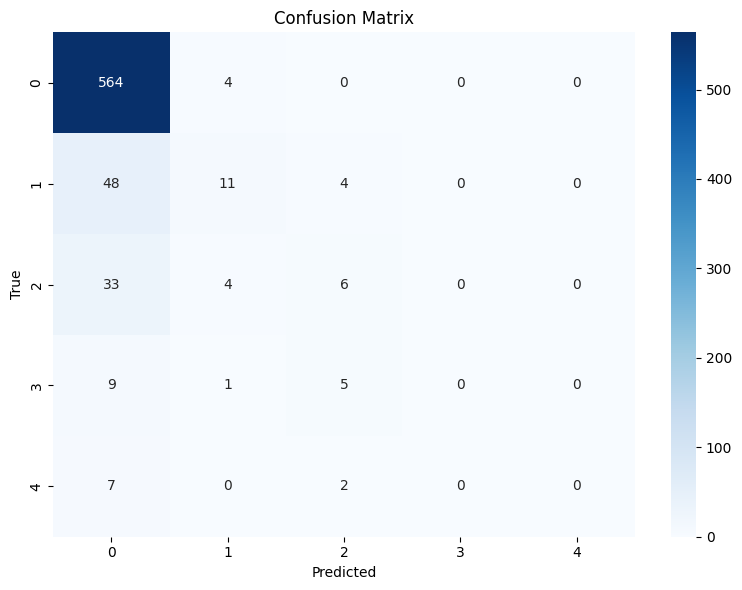


Test AUC (macro-average, OVR): 0.8760


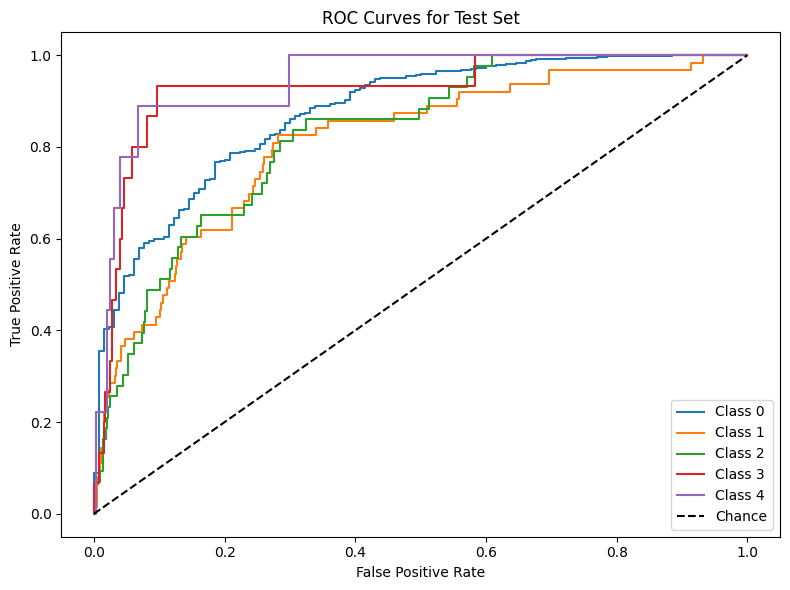

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       544
           1       0.29      0.03      0.06        59
           2       0.50      0.07      0.12        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.82       668
   macro avg       0.32      0.22      0.22       668
weighted avg       0.73      0.82      0.75       668



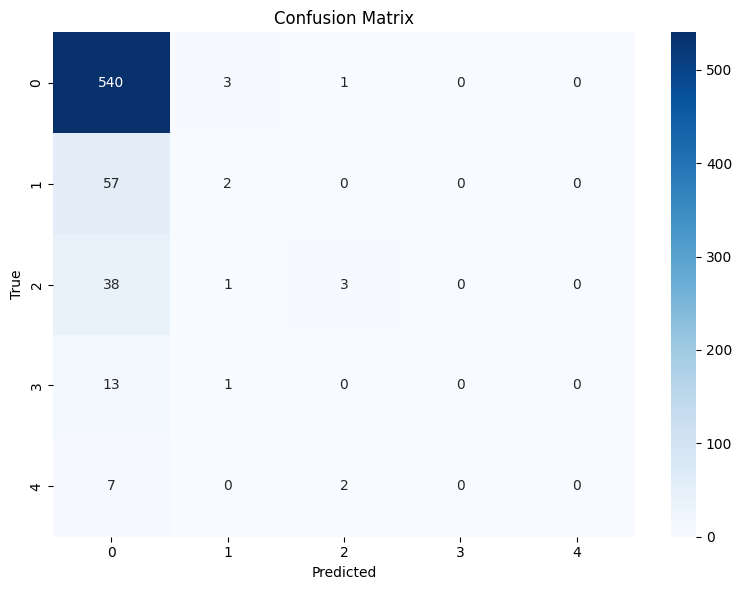


Test AUC (macro-average, OVR): 0.8601


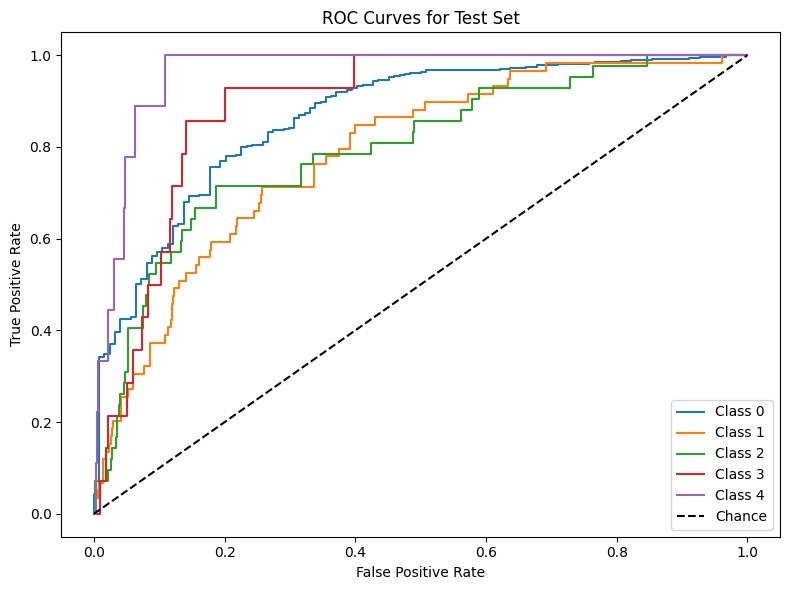

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       455
           1       1.00      0.02      0.04        52
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.82       554
   macro avg       0.36      0.20      0.19       554
weighted avg       0.77      0.82      0.74       554



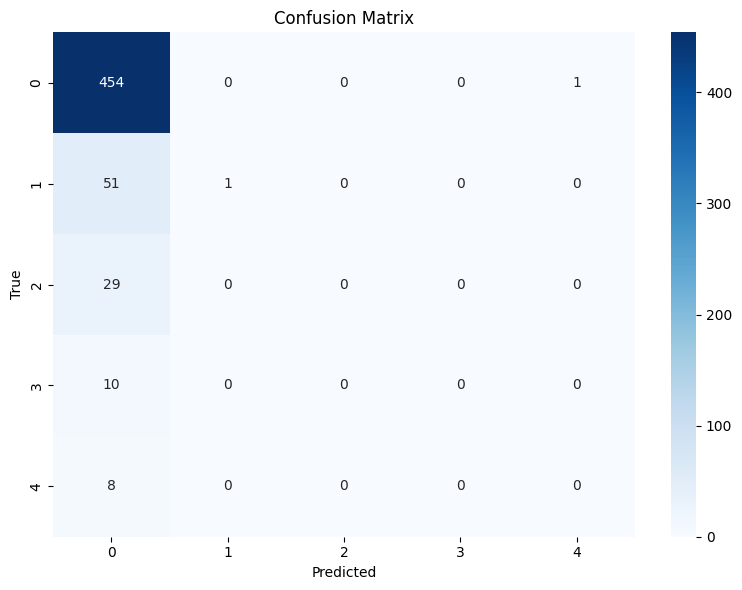


Test AUC (macro-average, OVR): 0.8198


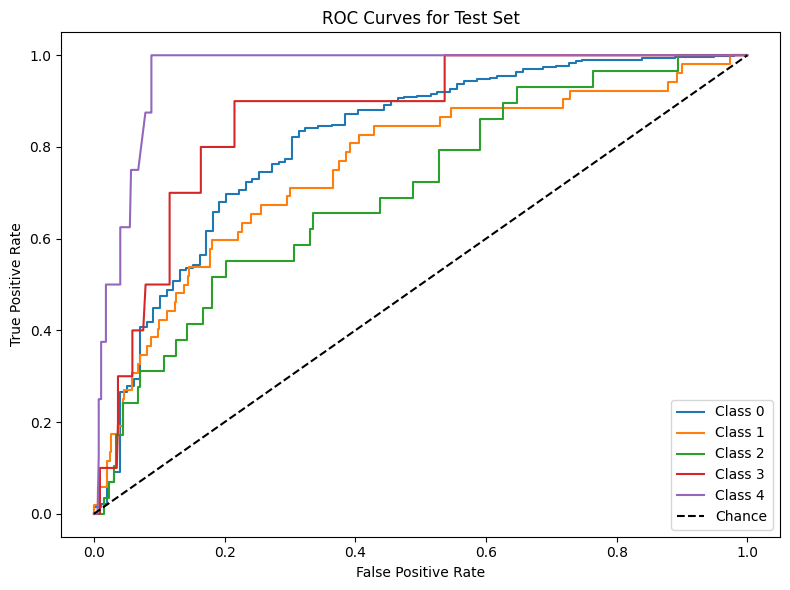

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       395
           1       0.57      0.10      0.17        40
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.83       477
   macro avg       0.28      0.22      0.22       477
weighted avg       0.74      0.83      0.77       477



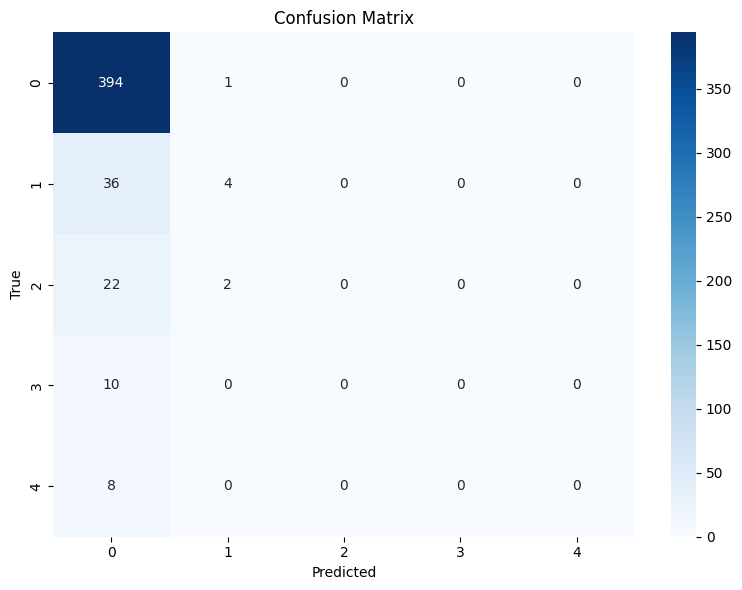


Test AUC (macro-average, OVR): 0.7625


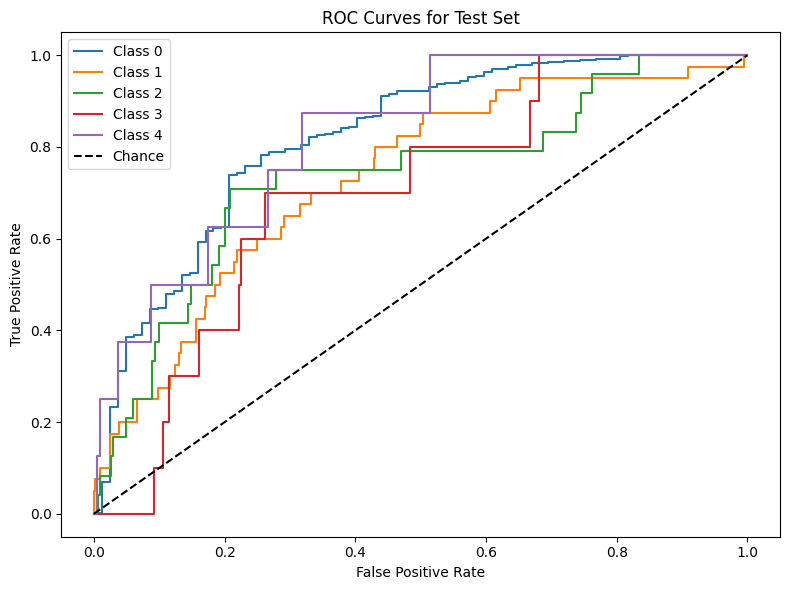

In [7]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample


=== Training Phase 1 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      1785
           1       0.52      0.46      0.49       604
           2       0.38      0.47      0.42       258
           3       0.24      0.34      0.28        59
           4       0.08      0.11      0.09         9

    accuracy                           0.69      2715
   macro avg       0.41      0.44      0.42      2715
weighted avg       0.70      0.69      0.70      2715



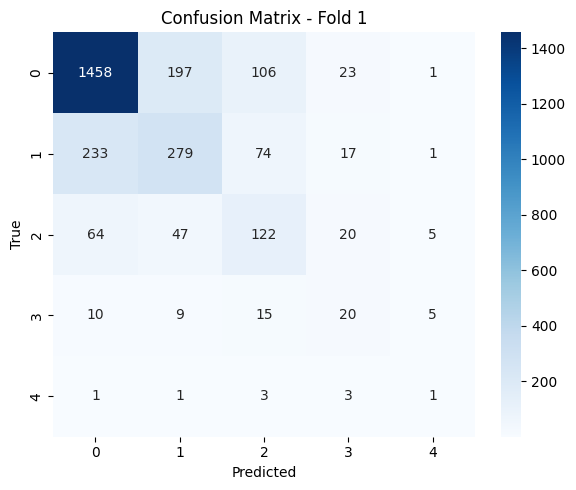

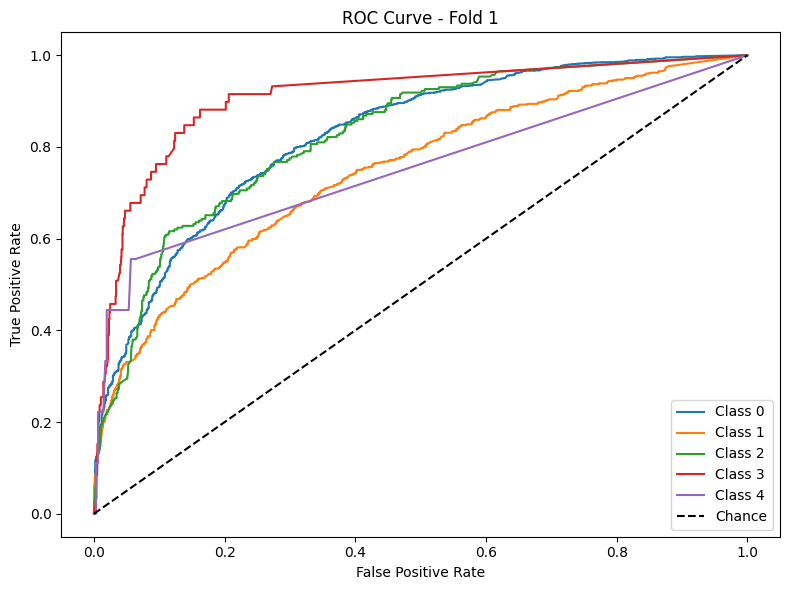


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      1786
           1       0.50      0.47      0.49       603
           2       0.43      0.50      0.46       258
           3       0.25      0.41      0.31        59
           4       0.11      0.12      0.12         8

    accuracy                           0.69      2714
   macro avg       0.42      0.46      0.44      2714
weighted avg       0.70      0.69      0.69      2714



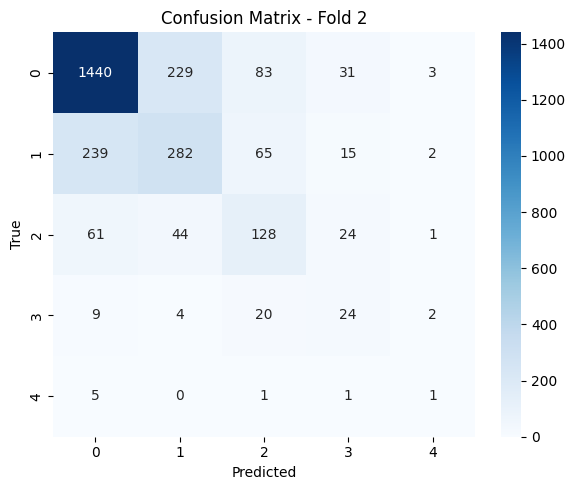

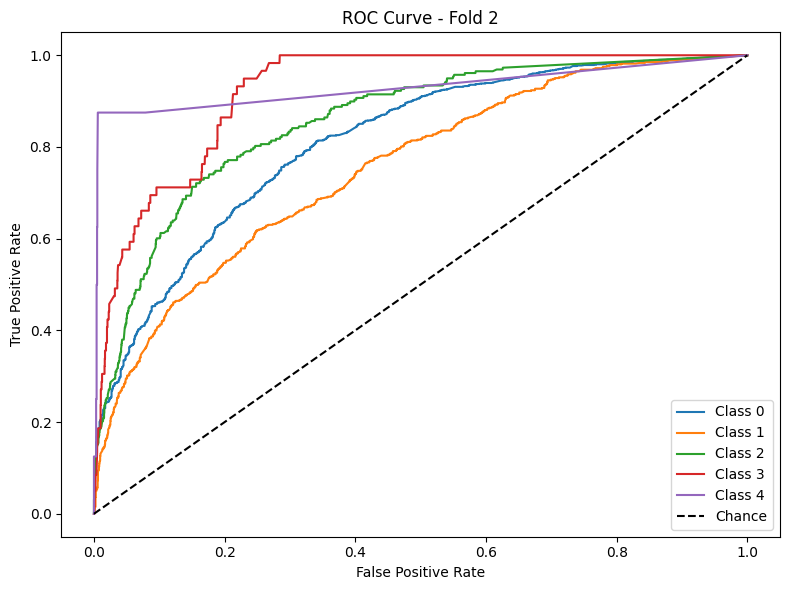


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      1786
           1       0.48      0.47      0.48       603
           2       0.42      0.55      0.48       258
           3       0.31      0.37      0.34        59
           4       0.14      0.12      0.13         8

    accuracy                           0.68      2714
   macro avg       0.44      0.46      0.45      2714
weighted avg       0.69      0.68      0.69      2714



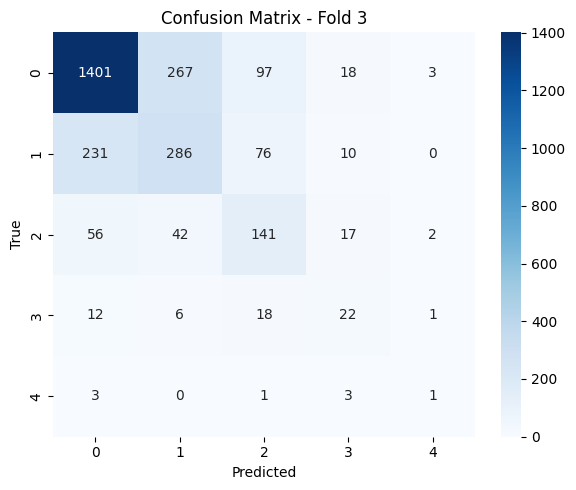

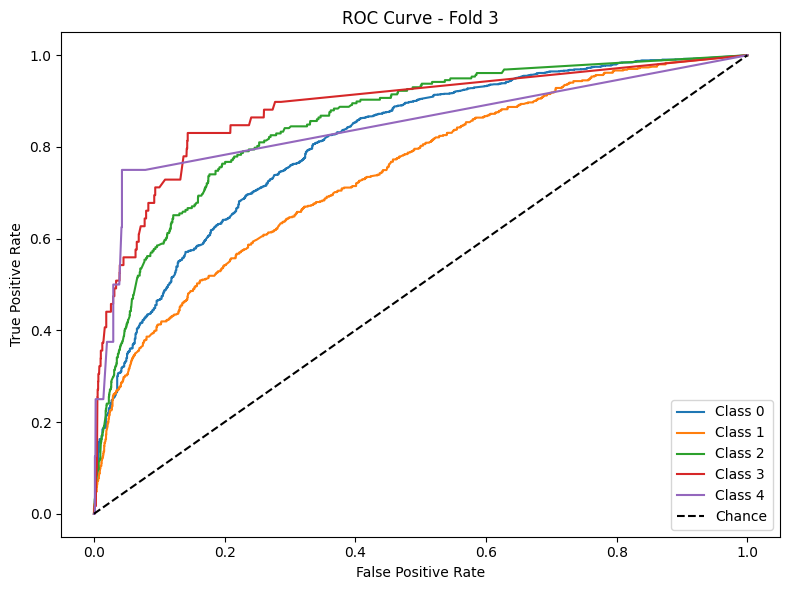


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      1785
           1       0.50      0.50      0.50       603
           2       0.42      0.52      0.47       258
           3       0.25      0.27      0.26        59
           4       0.25      0.11      0.15         9

    accuracy                           0.70      2714
   macro avg       0.45      0.44      0.44      2714
weighted avg       0.71      0.70      0.70      2714



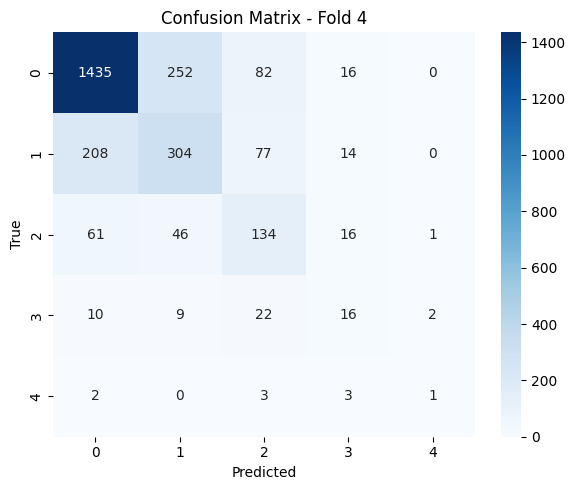

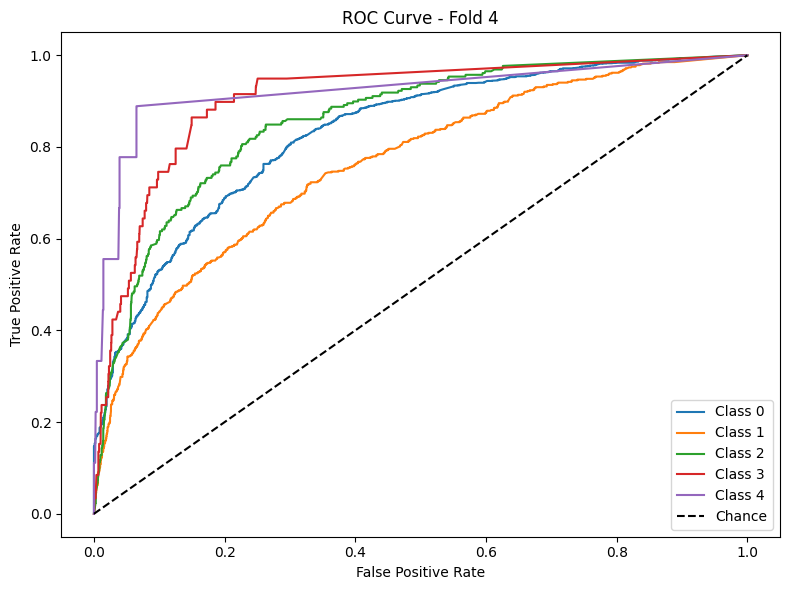


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81      1785
           1       0.48      0.45      0.46       603
           2       0.45      0.52      0.49       258
           3       0.21      0.32      0.26        59
           4       0.50      0.33      0.40         9

    accuracy                           0.68      2714
   macro avg       0.49      0.49      0.48      2714
weighted avg       0.69      0.68      0.69      2714



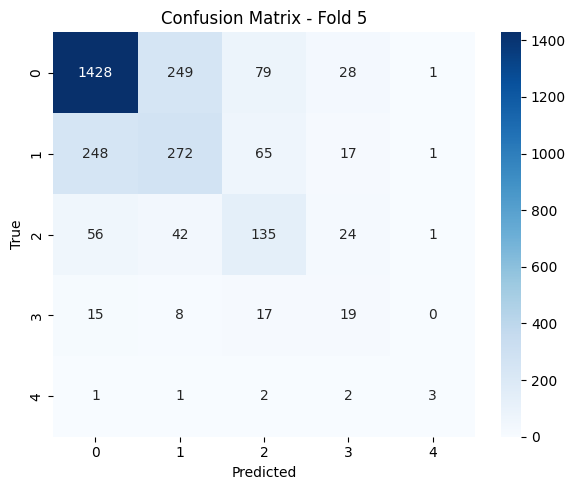

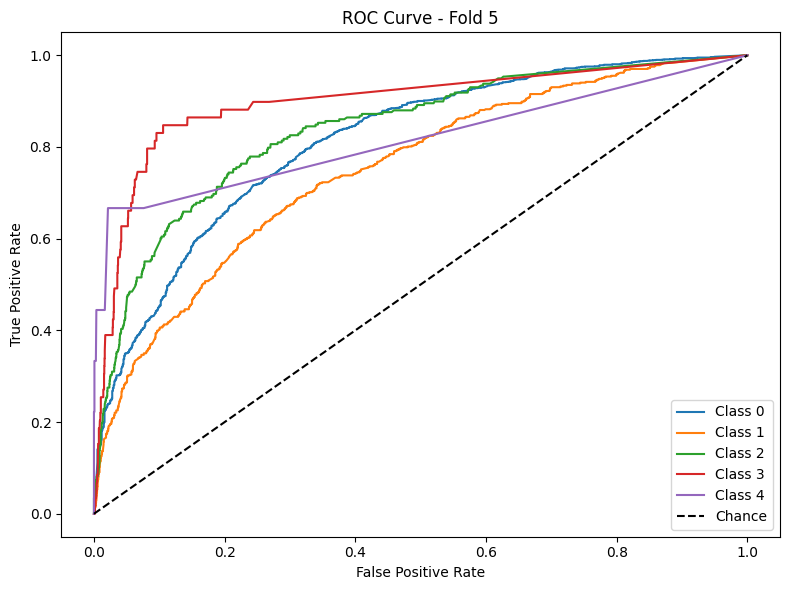


Average Accuracy: 0.6892
Average F1 Macro: 0.4454
Average AUC: 0.8345

Feature Importances:
remaining_time                         0.140771
cluster                                0.107422
assignment                             0.082817
video                                  0.077181
user_month                             0.060914
degree                                 0.051560
eigenvector                            0.047906
school                                 0.046640
encoded_field_sum                      0.046412
video_count                            0.040500
closeness                              0.039178
exercise_count                         0.033056
duration_days                          0.032009
chapter_count                          0.029120
total_words_phase1                     0.024343
total_neutral1                         0.017579
exercise_correct_sum_1                 0.014199
num_prerequisites                      0.011387
exercise_perc_real_score_mean_1        0.00

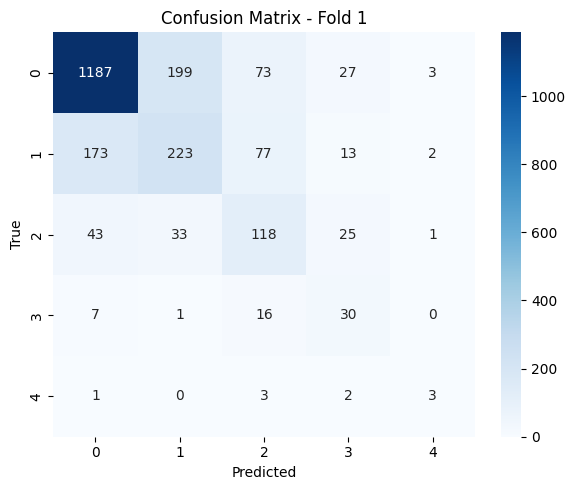

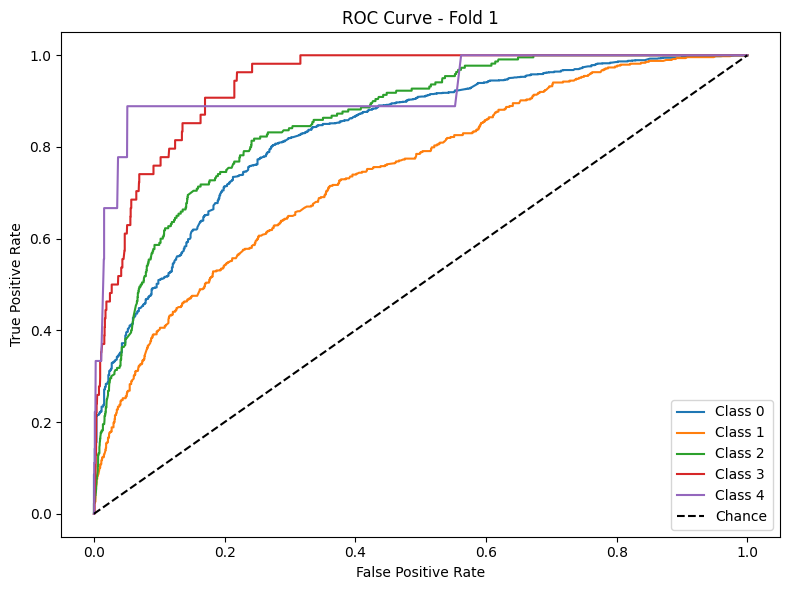


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.76      0.80      1489
           1       0.46      0.47      0.47       489
           2       0.35      0.43      0.38       219
           3       0.22      0.49      0.30        55
           4       0.19      0.38      0.25         8

    accuracy                           0.66      2260
   macro avg       0.41      0.51      0.44      2260
weighted avg       0.69      0.66      0.67      2260



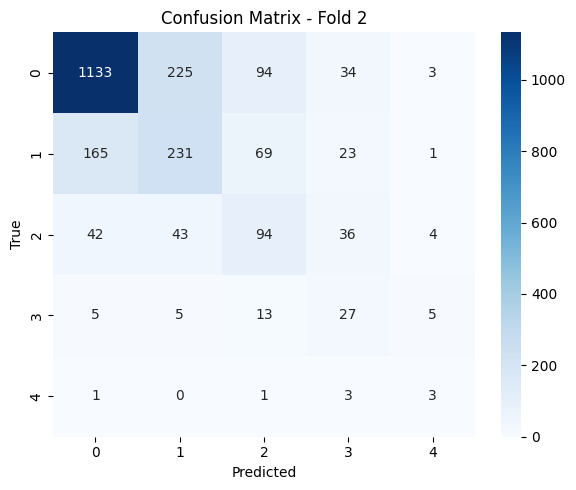

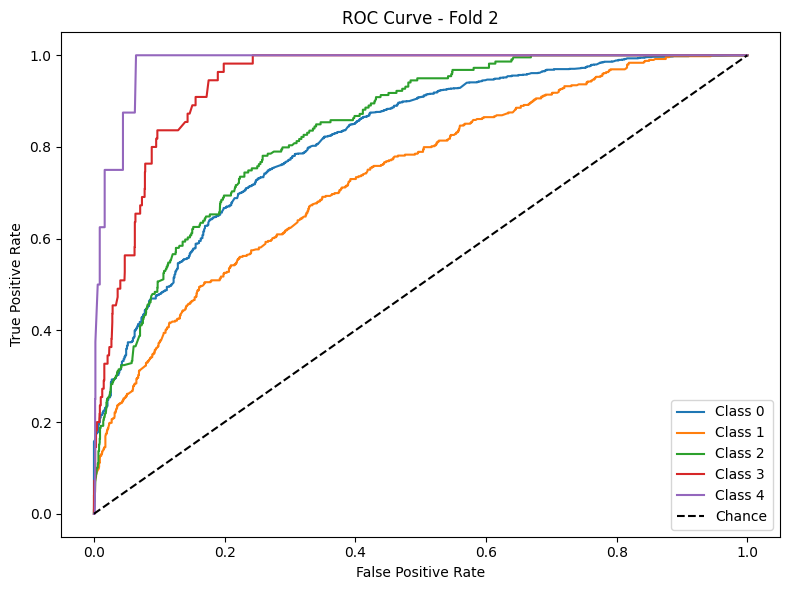


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81      1489
           1       0.47      0.46      0.46       489
           2       0.45      0.51      0.48       219
           3       0.24      0.43      0.31        54
           4       0.25      0.50      0.33         8

    accuracy                           0.69      2259
   macro avg       0.45      0.54      0.48      2259
weighted avg       0.70      0.69      0.69      2259



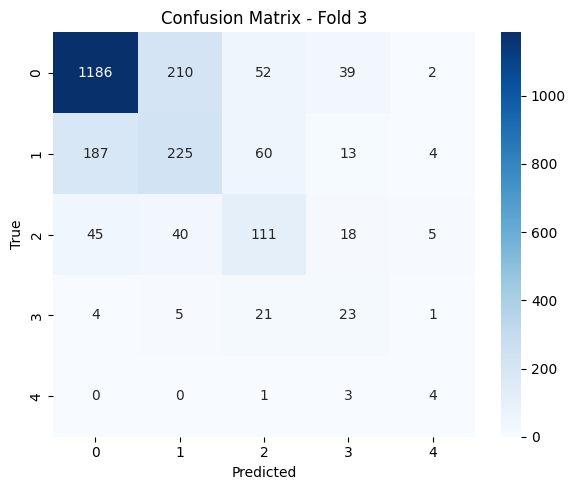

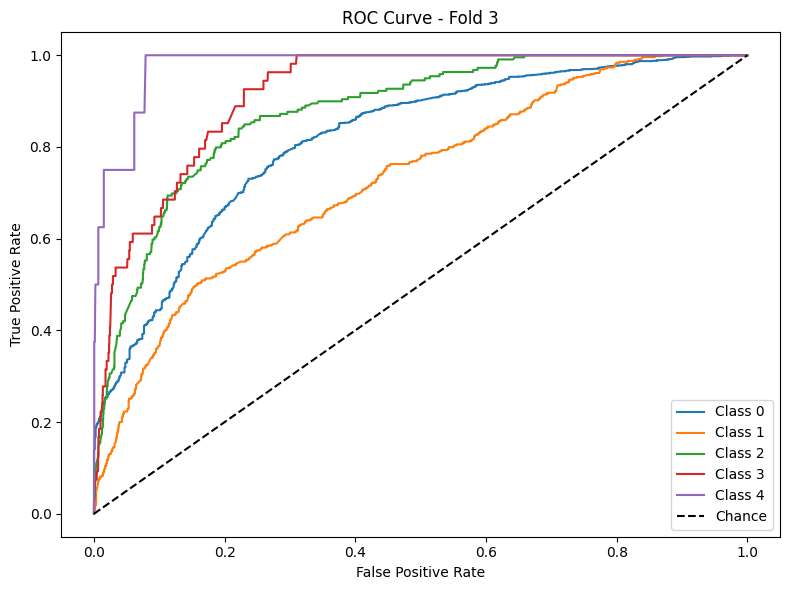


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      1489
           1       0.50      0.47      0.49       489
           2       0.40      0.53      0.46       219
           3       0.34      0.52      0.41        54
           4       0.50      0.50      0.50         8

    accuracy                           0.69      2259
   macro avg       0.52      0.56      0.53      2259
weighted avg       0.70      0.69      0.70      2259



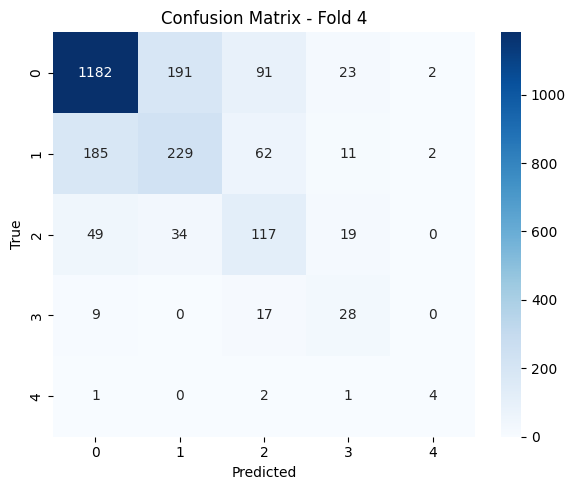

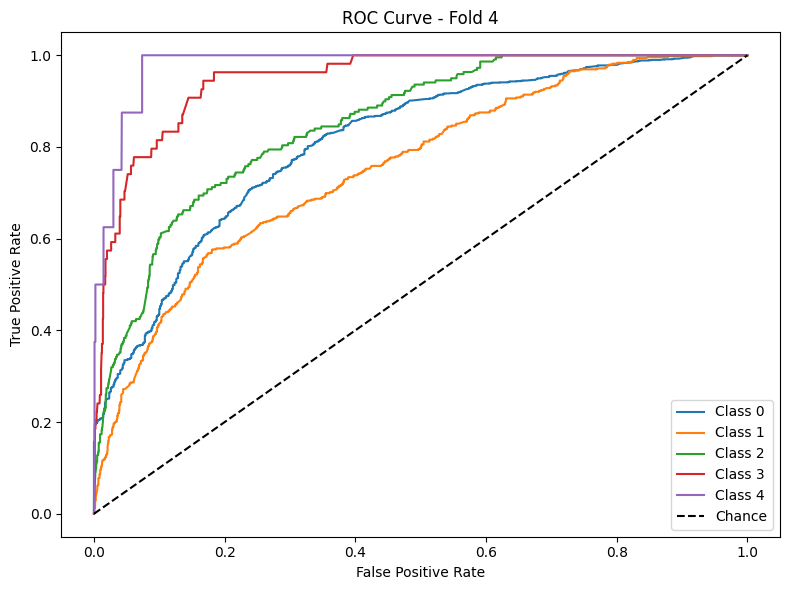


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.82      1490
           1       0.49      0.50      0.50       488
           2       0.41      0.54      0.46       219
           3       0.24      0.30      0.26        54
           4       0.10      0.12      0.11         8

    accuracy                           0.69      2259
   macro avg       0.42      0.45      0.43      2259
weighted avg       0.71      0.69      0.70      2259



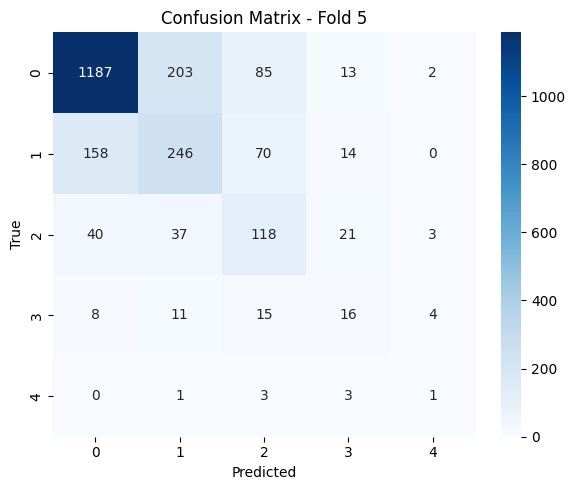

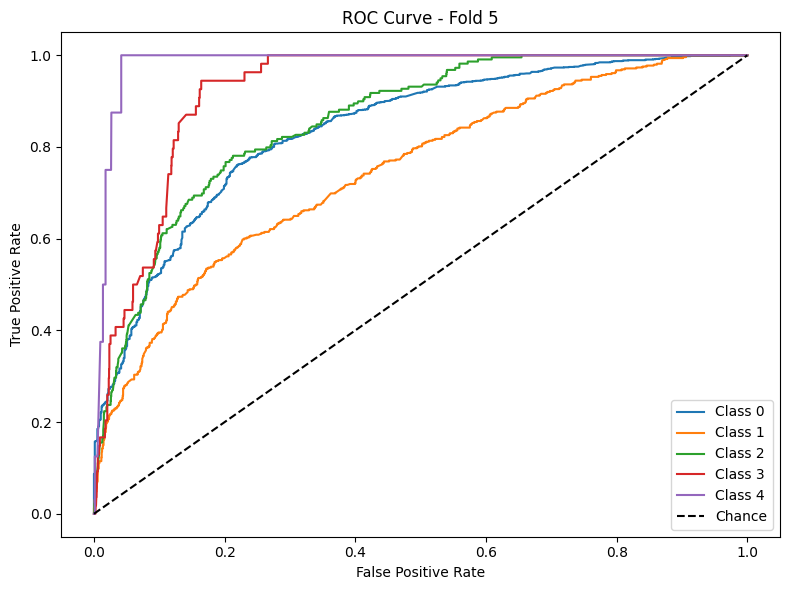


Average Accuracy: 0.6839
Average F1 Macro: 0.4767
Average AUC: 0.8650

Feature Importances:
remaining_time                         0.091248
assignment                             0.086806
video                                  0.085802
cluster                                0.074304
user_month                             0.058743
degree                                 0.057453
video_count                            0.054228
eigenvector                            0.053960
encoded_field_sum                      0.053532
closeness                              0.044727
exercise_count                         0.042873
school                                 0.038778
duration_days                          0.038094
chapter_count                          0.038034
total_words_phase1                     0.020834
num_prerequisites                      0.016806
total_neutral1                         0.014952
user_past_course_count                 0.009747
total_words_phase2                     0.00

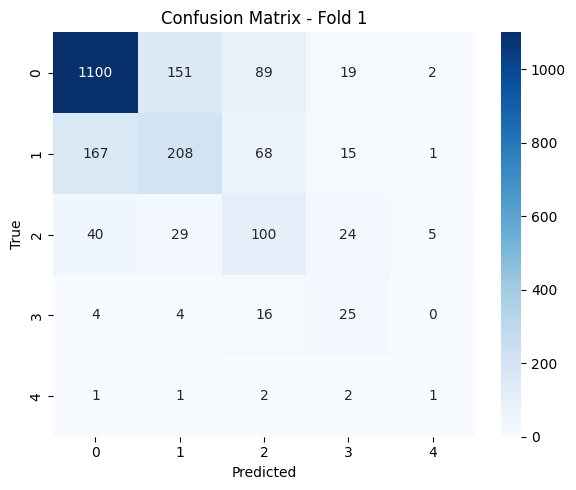

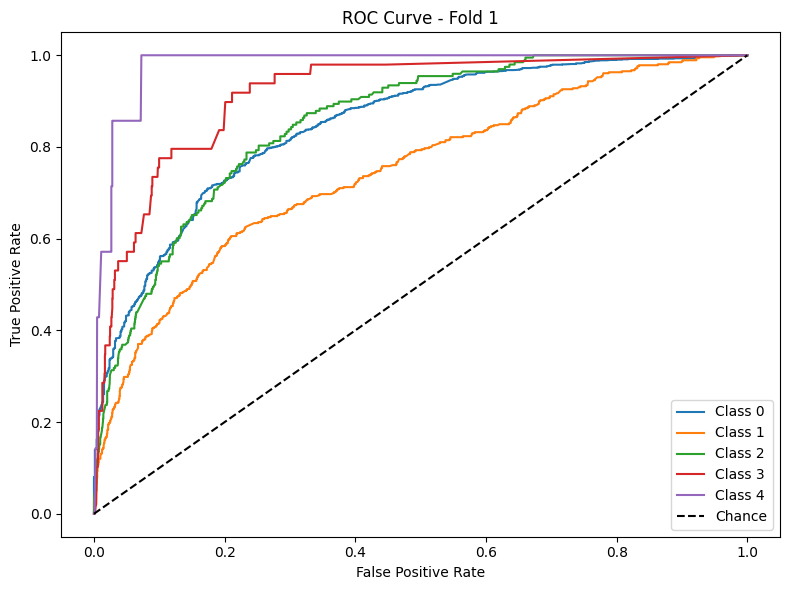


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81      1360
           1       0.50      0.48      0.49       459
           2       0.42      0.53      0.46       198
           3       0.31      0.42      0.36        50
           4       0.20      0.14      0.17         7

    accuracy                           0.69      2074
   macro avg       0.45      0.47      0.46      2074
weighted avg       0.70      0.69      0.70      2074



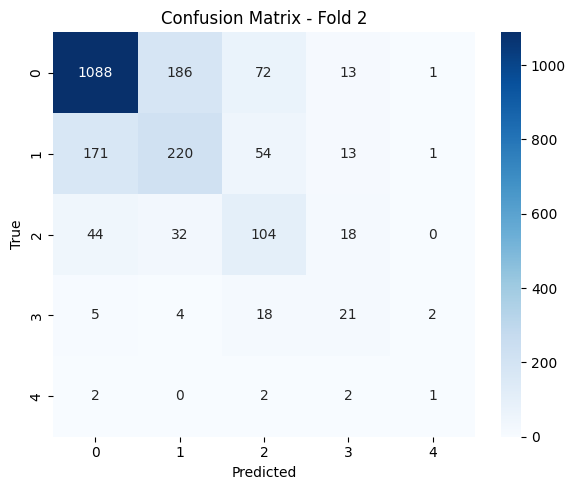

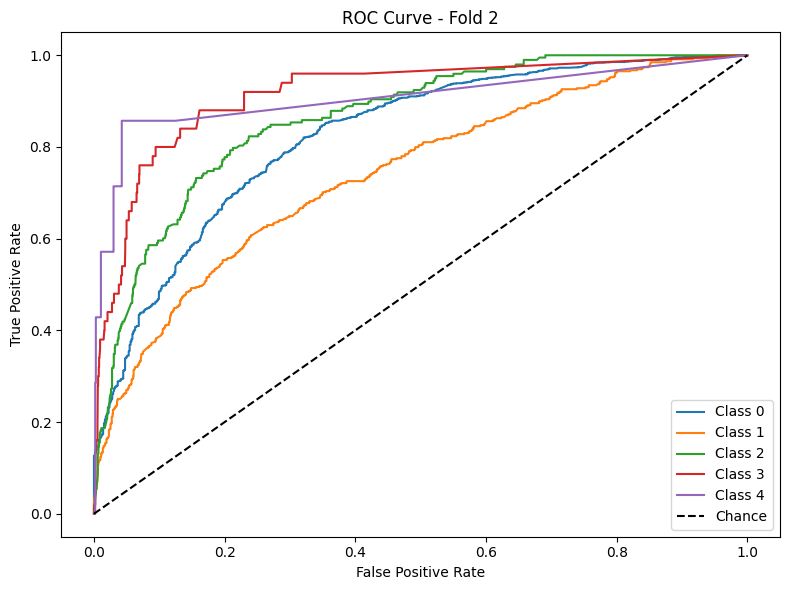


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      1360
           1       0.49      0.47      0.48       459
           2       0.38      0.51      0.43       198
           3       0.24      0.38      0.29        50
           4       0.29      0.29      0.29         7

    accuracy                           0.68      2074
   macro avg       0.45      0.49      0.46      2074
weighted avg       0.70      0.68      0.69      2074



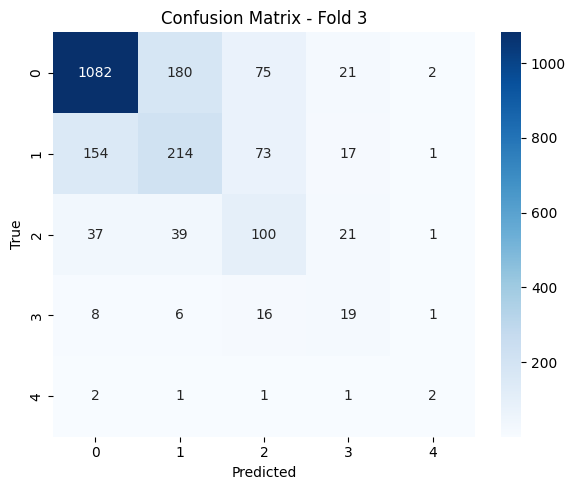

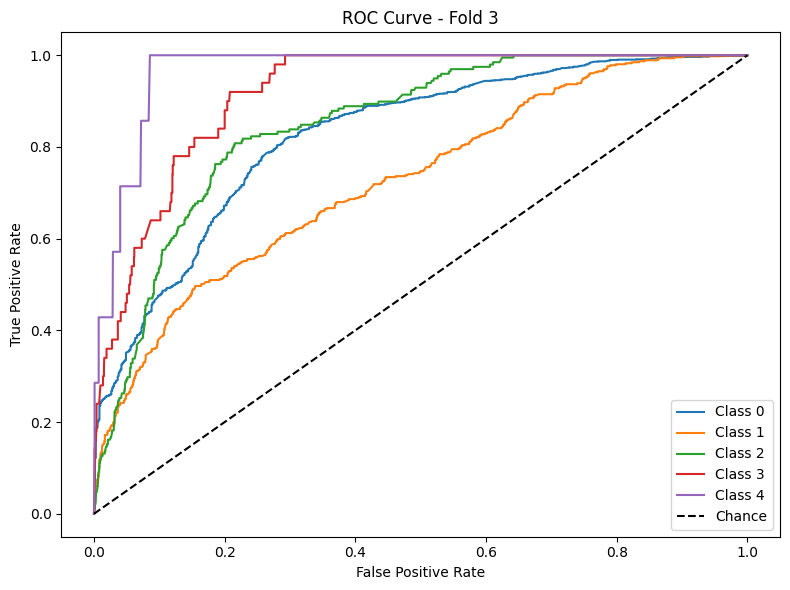


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.81      1360
           1       0.46      0.44      0.45       459
           2       0.41      0.47      0.44       198
           3       0.25      0.36      0.30        50
           4       0.14      0.14      0.14         7

    accuracy                           0.67      2074
   macro avg       0.42      0.44      0.43      2074
weighted avg       0.68      0.67      0.68      2074



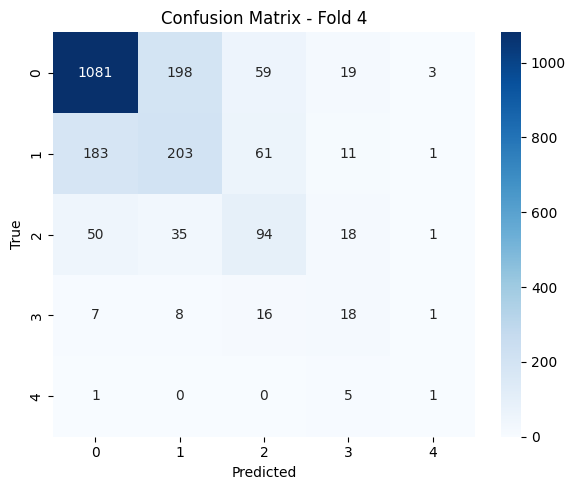

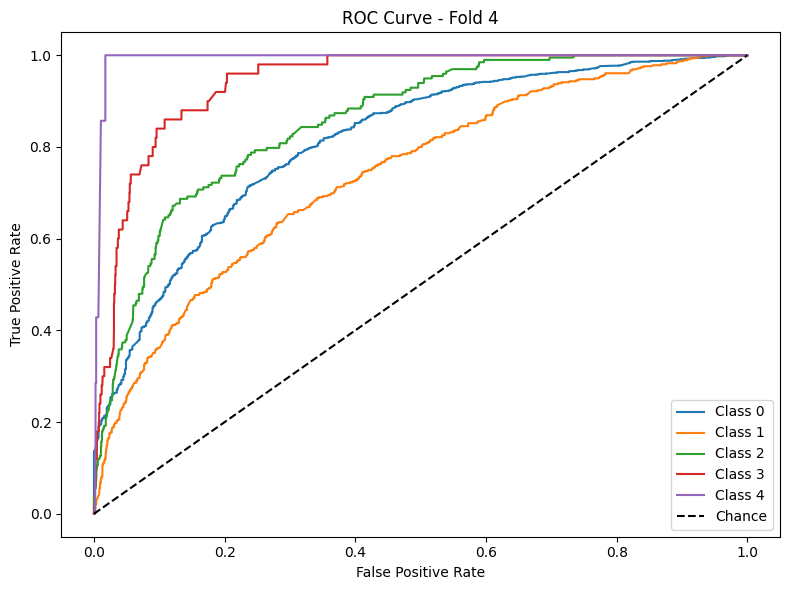


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80      1360
           1       0.46      0.48      0.47       460
           2       0.39      0.53      0.45       197
           3       0.29      0.33      0.31        49
           4       0.25      0.14      0.18         7

    accuracy                           0.67      2073
   macro avg       0.44      0.45      0.44      2073
weighted avg       0.69      0.67      0.68      2073



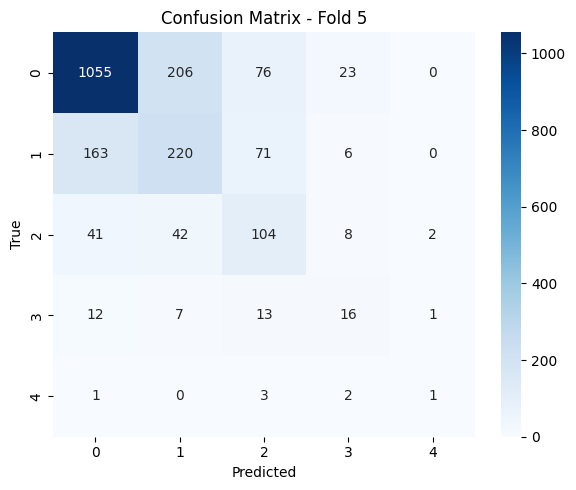

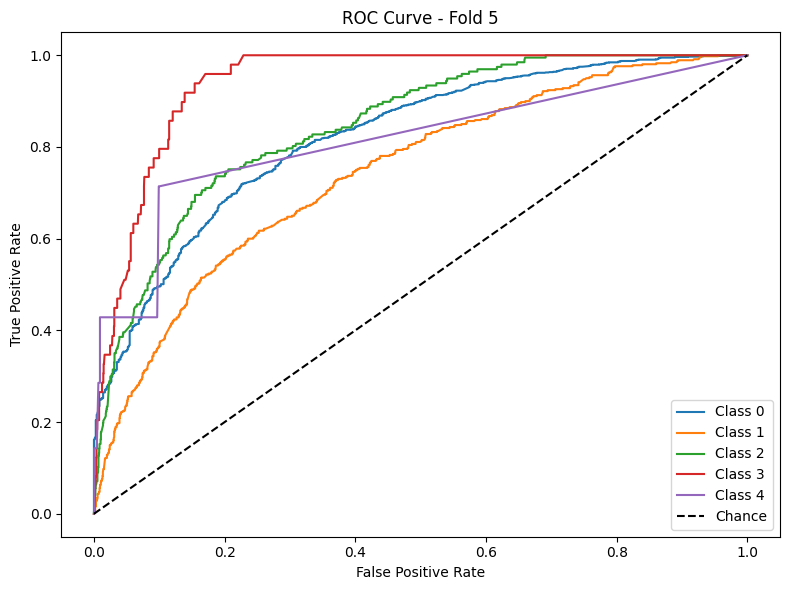


Average Accuracy: 0.6826
Average F1 Macro: 0.4471
Average AUC: 0.8556

Feature Importances:
remaining_time                         0.101240
assignment                             0.077577
video                                  0.076107
cluster                                0.071765
degree                                 0.058894
eigenvector                            0.058441
encoded_field_sum                      0.054648
user_month                             0.050955
closeness                              0.046168
school                                 0.043185
video_count                            0.041293
chapter_count                          0.039932
exercise_count                         0.039327
duration_days                          0.035912
total_words_phase1                     0.019709
num_prerequisites                      0.015953
total_neutral1                         0.015238
total_words_phase3                     0.012896
user_past_course_count                 0.01

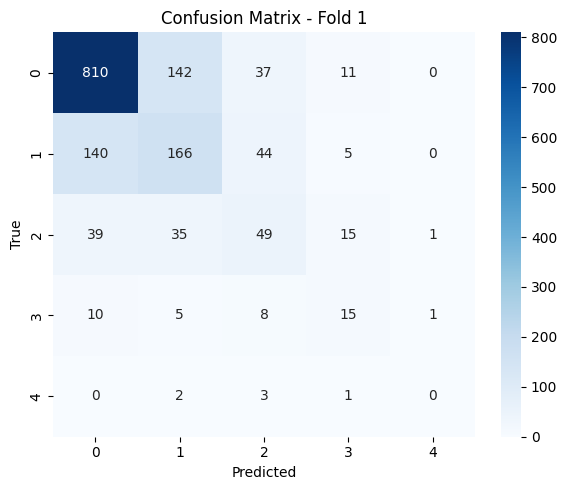

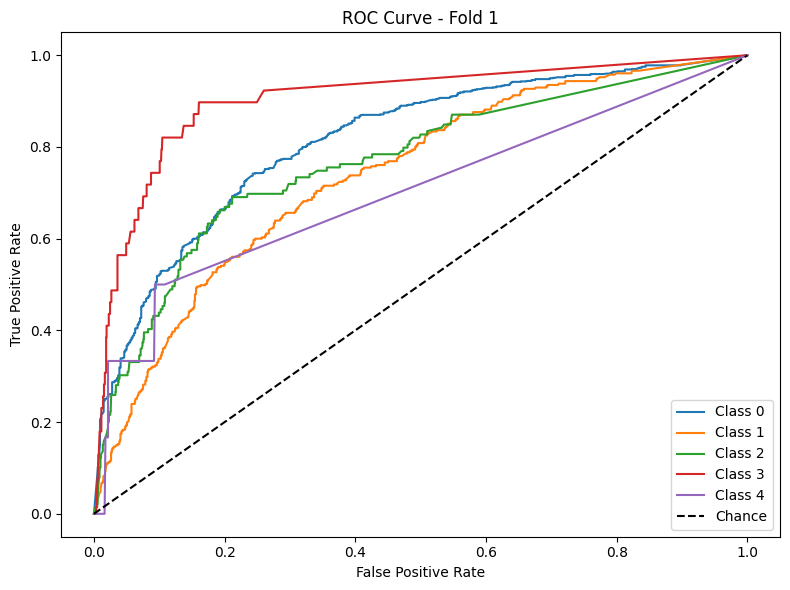


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1000
           1       0.52      0.49      0.50       355
           2       0.46      0.48      0.47       139
           3       0.29      0.28      0.28        40
           4       0.00      0.00      0.00         5

    accuracy                           0.70      1539
   macro avg       0.42      0.41      0.41      1539
weighted avg       0.70      0.70      0.70      1539



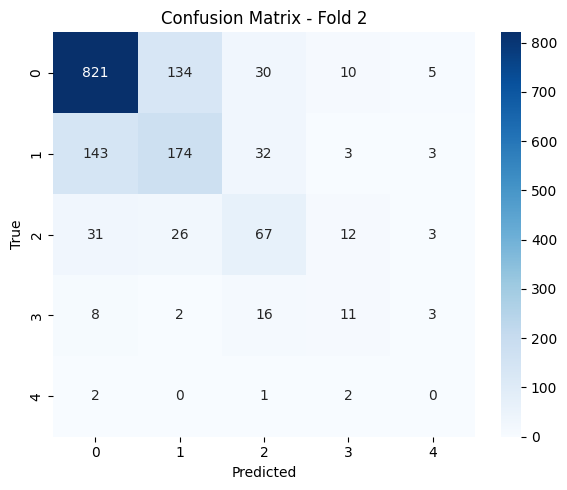

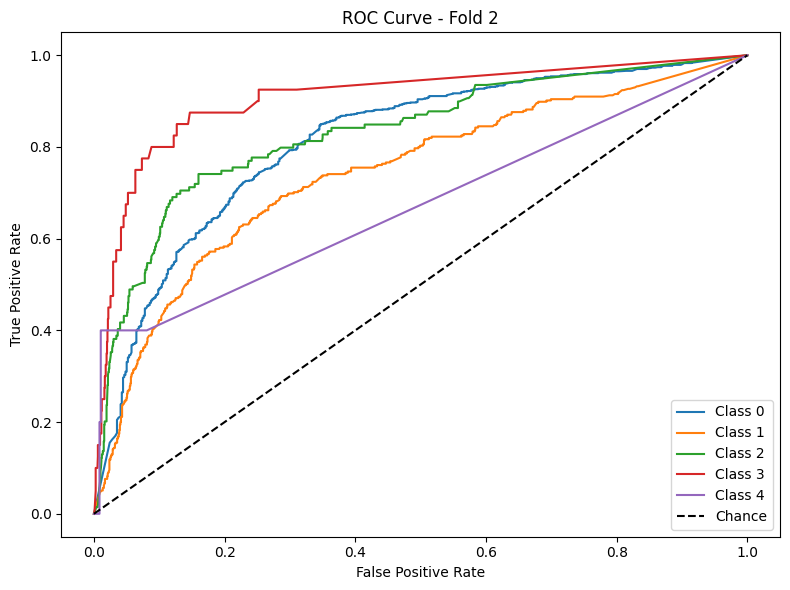


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81       999
           1       0.51      0.52      0.51       355
           2       0.44      0.48      0.46       139
           3       0.37      0.38      0.37        40
           4       0.00      0.00      0.00         6

    accuracy                           0.70      1539
   macro avg       0.43      0.44      0.43      1539
weighted avg       0.70      0.70      0.70      1539



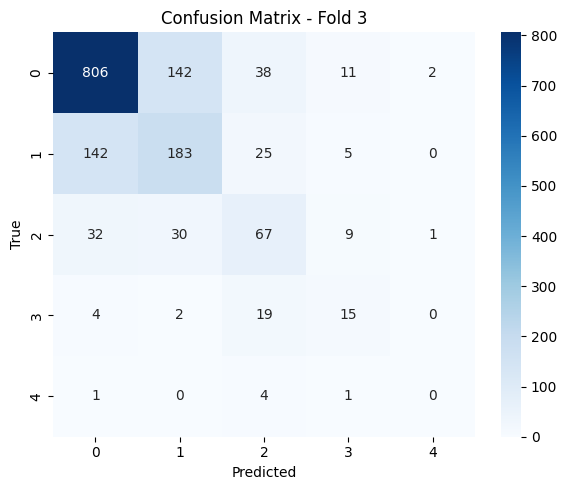

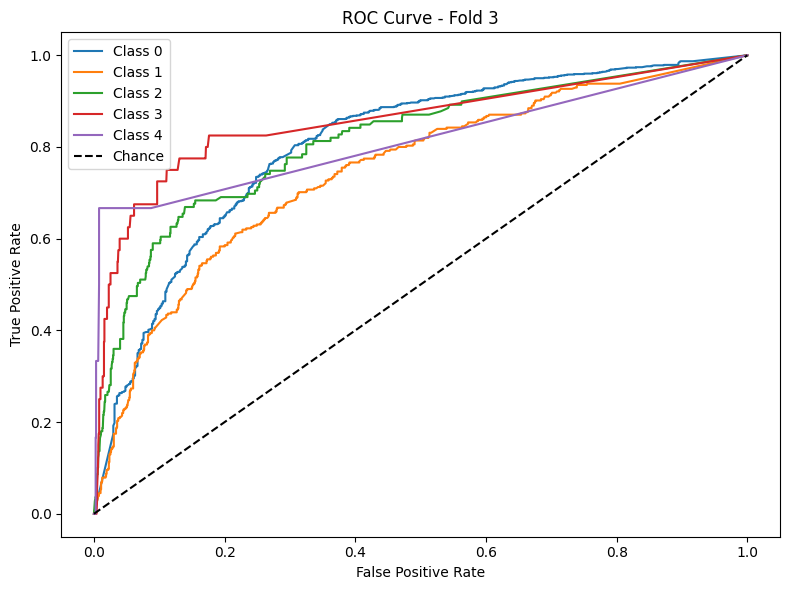


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       999
           1       0.53      0.49      0.51       356
           2       0.41      0.44      0.43       138
           3       0.28      0.36      0.31        39
           4       0.12      0.17      0.14         6

    accuracy                           0.70      1538
   macro avg       0.43      0.46      0.44      1538
weighted avg       0.70      0.70      0.70      1538



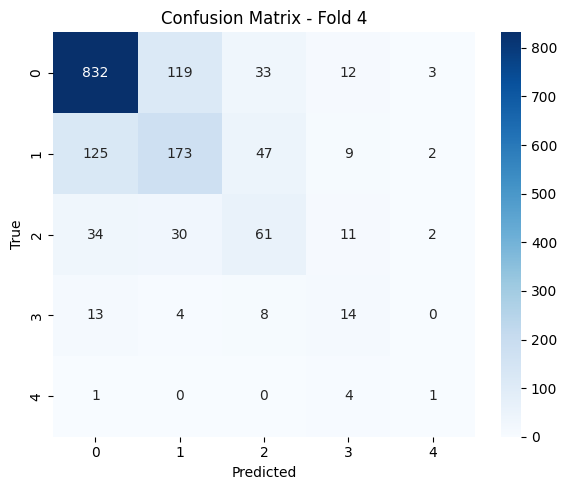

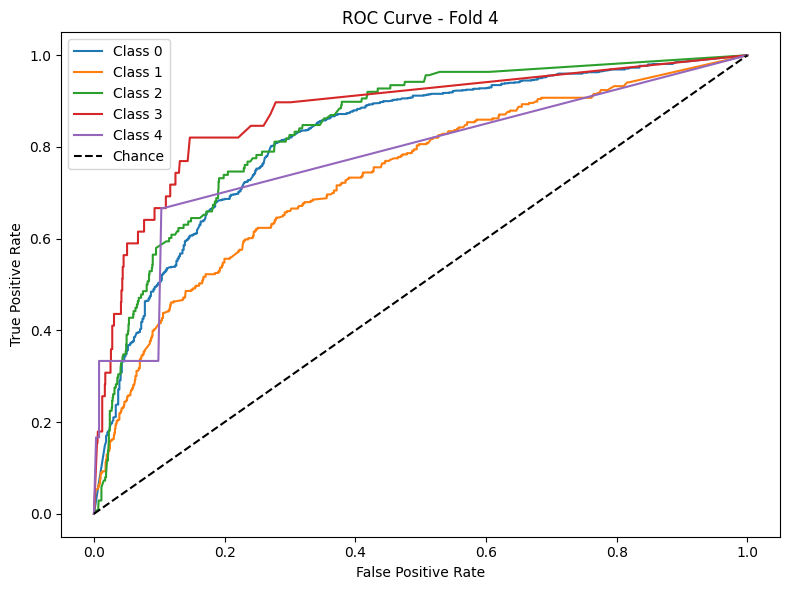


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.81       999
           1       0.46      0.44      0.45       356
           2       0.41      0.43      0.42       138
           3       0.43      0.49      0.46        39
           4       0.00      0.00      0.00         6

    accuracy                           0.68      1538
   macro avg       0.42      0.43      0.43      1538
weighted avg       0.68      0.68      0.68      1538



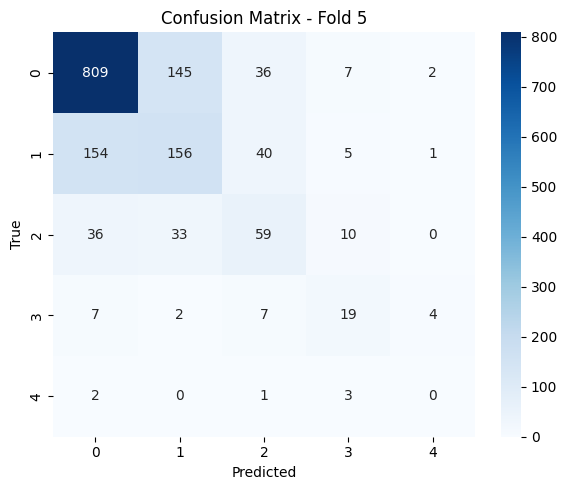

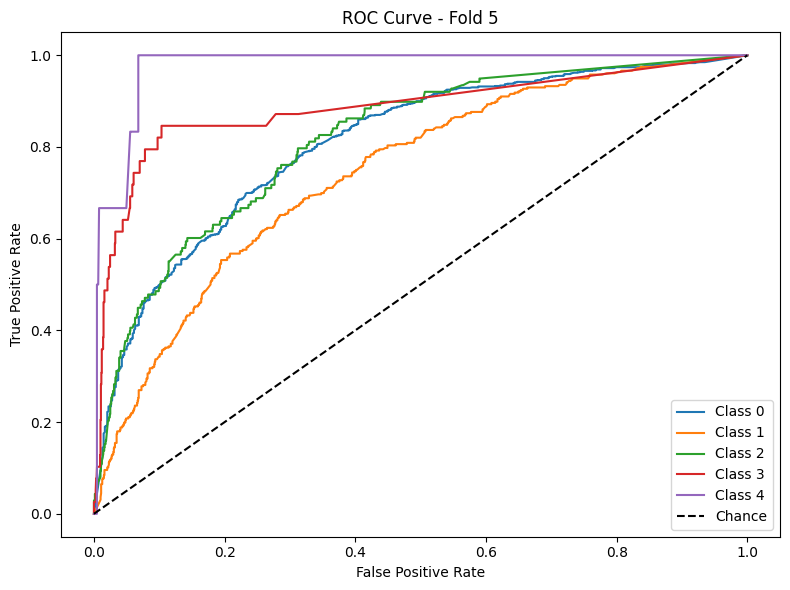


Average Accuracy: 0.6900
Average F1 Macro: 0.4226
Average AUC: 0.8087

Feature Importances:
cluster                                0.103794
remaining_time                         0.097016
assignment                             0.075330
video                                  0.070863
degree                                 0.056575
eigenvector                            0.048767
video_count                            0.043595
user_month                             0.043075
encoded_field_sum                      0.042969
school                                 0.040111
closeness                              0.035573
chapter_count                          0.032914
duration_days                          0.030433
exercise_count                         0.028224
total_words_phase1                     0.020348
total_neutral1                         0.014828
num_prerequisites                      0.012514
total_words_phase4                     0.011388
total_positive1                        0.00

In [8]:
phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       568
           1       0.30      0.25      0.28        63
           2       0.33      0.26      0.29        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.80       698
   macro avg       0.30      0.29      0.29       698
weighted avg       0.76      0.80      0.78       698



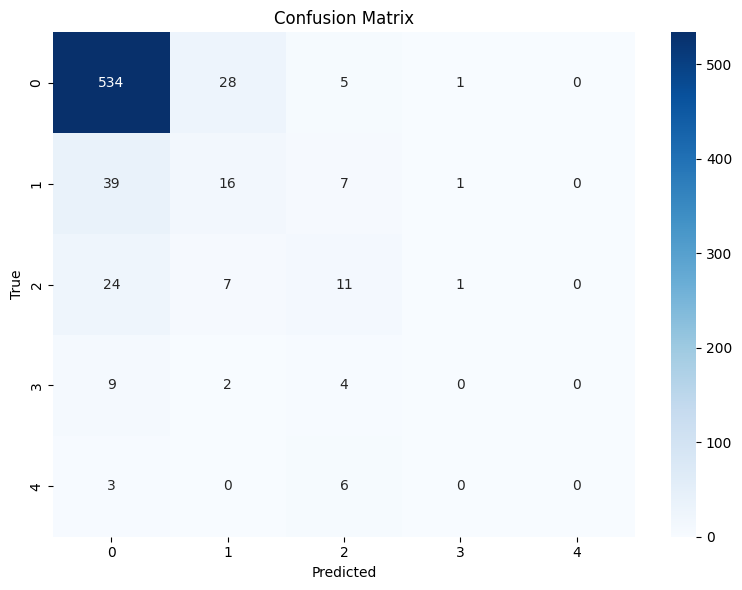


Test AUC (macro-average, OVR): 0.8199


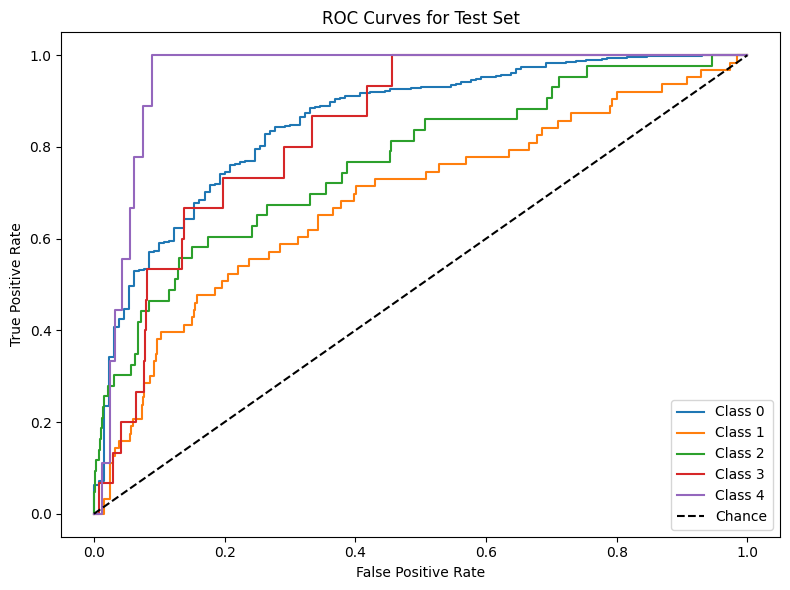

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       544
           1       0.28      0.17      0.21        59
           2       0.30      0.19      0.23        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.81       668
   macro avg       0.29      0.26      0.27       668
weighted avg       0.75      0.81      0.77       668



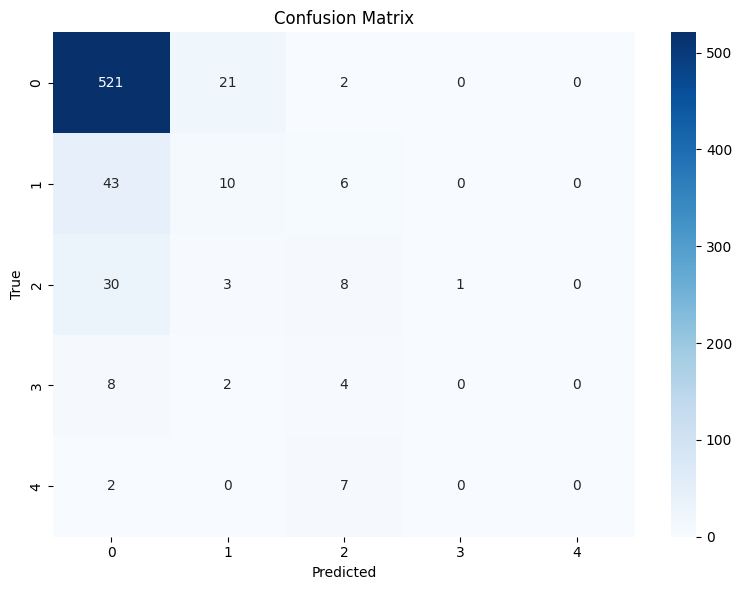


Test AUC (macro-average, OVR): 0.8063


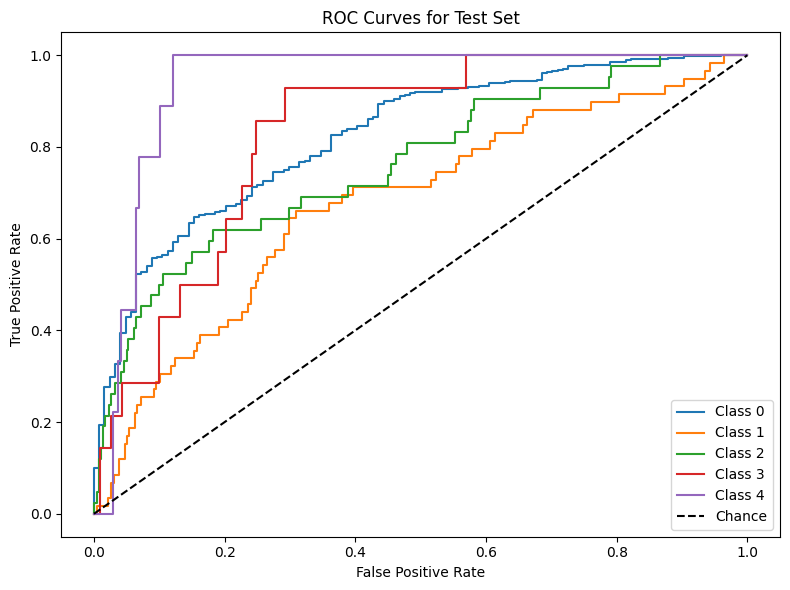

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       455
           1       0.23      0.15      0.18        52
           2       0.07      0.03      0.05        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.79       554
   macro avg       0.23      0.22      0.22       554
weighted avg       0.72      0.79      0.75       554



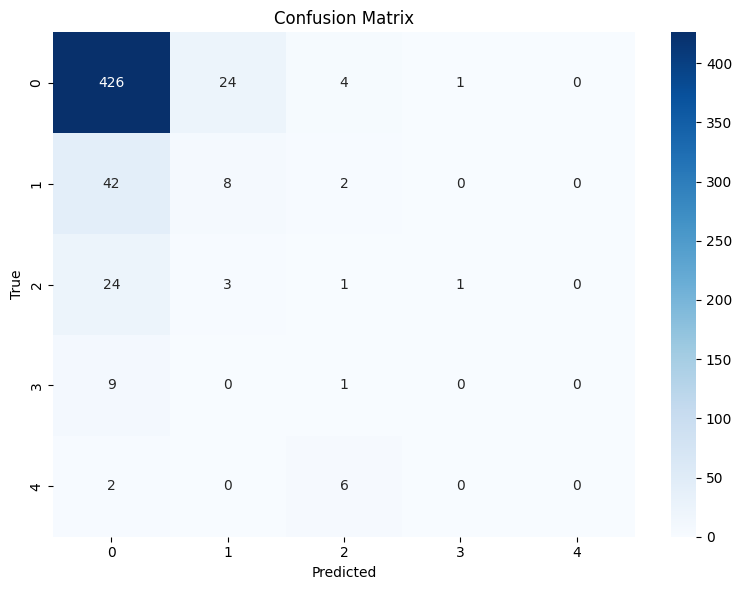


Test AUC (macro-average, OVR): 0.7263


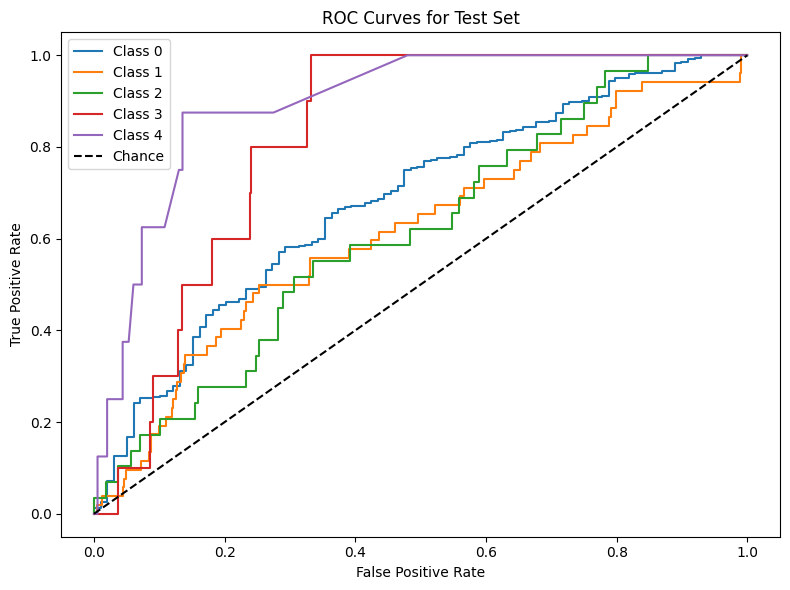

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       395
           1       0.17      0.12      0.14        40
           2       0.08      0.04      0.06        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.79       477
   macro avg       0.22      0.22      0.22       477
weighted avg       0.73      0.79      0.76       477



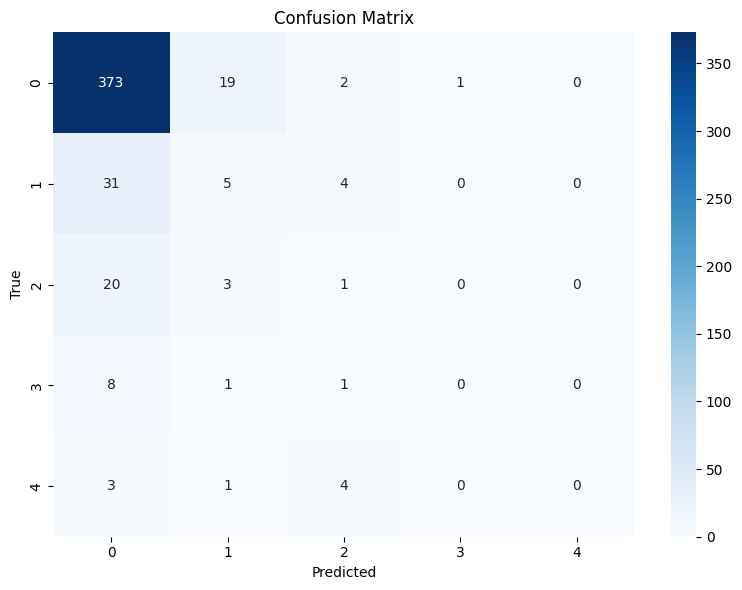


Test AUC (macro-average, OVR): 0.7434


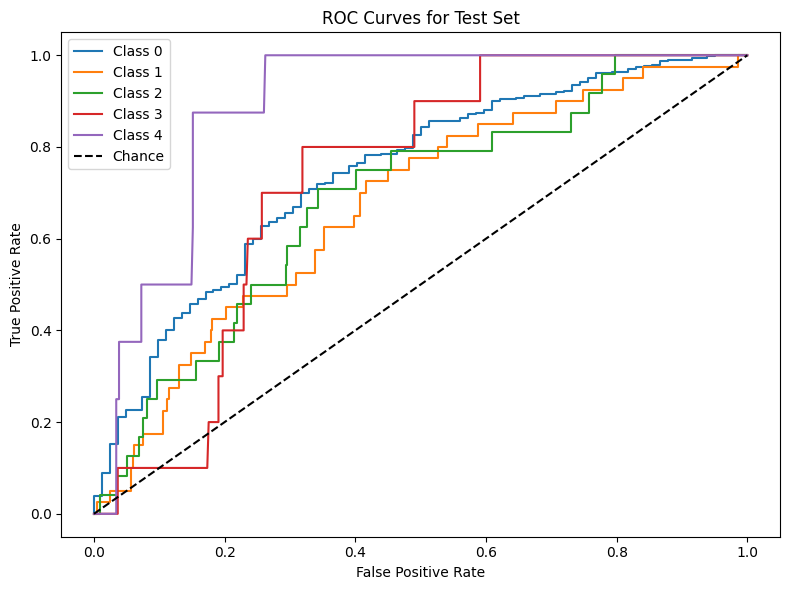

In [9]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
